In [2]:
# Special directive to Jupiter Notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

##Import any other packages you may need here
from itertools import chain
from random import sample 
import scipy
# Read and show xray
from skimage.io import imread, imshow

import pydicom
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the some EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Below is some helper code to read data for you.
## Load NIH data by passing the path to the file

# Path of the file to read
filepath = '/data/Data_Entry_2017.csv'

# Read the file into a variable all_xray_df
all_xray_df = pd.read_csv(filepath)


all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
44576,00011460_050.png,Pneumothorax,50,11460,16,M,PA,2256,2619,0.143,0.143,NaN
22567,00005979_000.png,No Finding,0,5979,10,M,PA,2048,2500,0.171,0.171,NaN
44387,00011420_021.png,Infiltration,21,11420,69,F,PA,2992,2991,0.143,0.143,NaN


### Exploriatory Data Analysis
**1. Label distribution on the data**

In [5]:
## Here I'm just going to split up my "Finding Labels" column by the | symbol separator 
# so that I have one column per disease in my dataframe,
# with a binary flag. This makes EDA a lot easier! 

# maps/gets each row of the Finding label column and split it using the '|' character as separable. 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
# Distribution of diseases
# all_labels variable is a list of all these columns
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

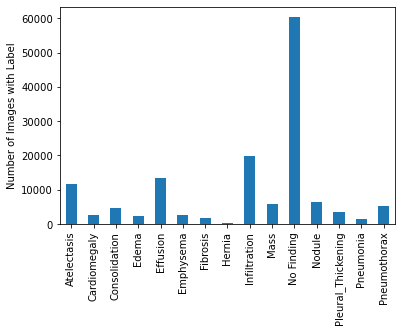

In [7]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

As expected pneumonia only constitute only 1% of the dataset. 50% of the data constitute no findings and the rest 40% are concurrent diseases. Of the 40% concurrent diseases, Infilteration, Effusion and Atectasis are the most common. Overall , negative finding with respect to pneumonia classes is 90% of the dataset.

### 1.1 Absolute count of each disease
That occured concurrently with pneumonia


In [8]:
# Pull the first disease
comorb1 = all_xray_df['Image Index'][0]
comorb1

'00000001_000.png'

In [9]:
#img = imread(comorb1)

In [10]:
# Absolute total count of each disease
diseases_freq ={}
all_labels = ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']
for i in all_labels:
    # Use each disease as the key, then count each time I see the key with pnueumonia
    diseases_freq[i] = len(all_xray_df[all_xray_df.Pneumonia==1][all_xray_df[i]==1])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [11]:
diseases_freq

{'Atelectasis': 262,
 'Effusion': 269,
 'Pneumothorax': 41,
 'Infiltration': 605,
 'Cardiomegaly': 41,
 'Mass': 71,
 'Nodule': 70}

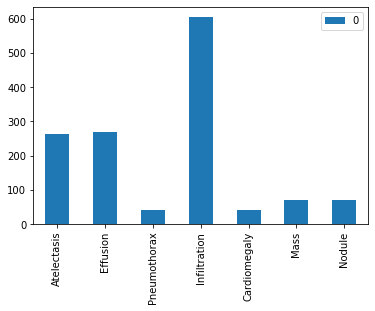

In [12]:
# Creating dataframe by converting dict to list of items
ds = pd.DataFrame.from_dict(diseases_freq, orient='index').plot(kind='bar')


### 1.2 Thirty most concurrent diseases with Pneumonia

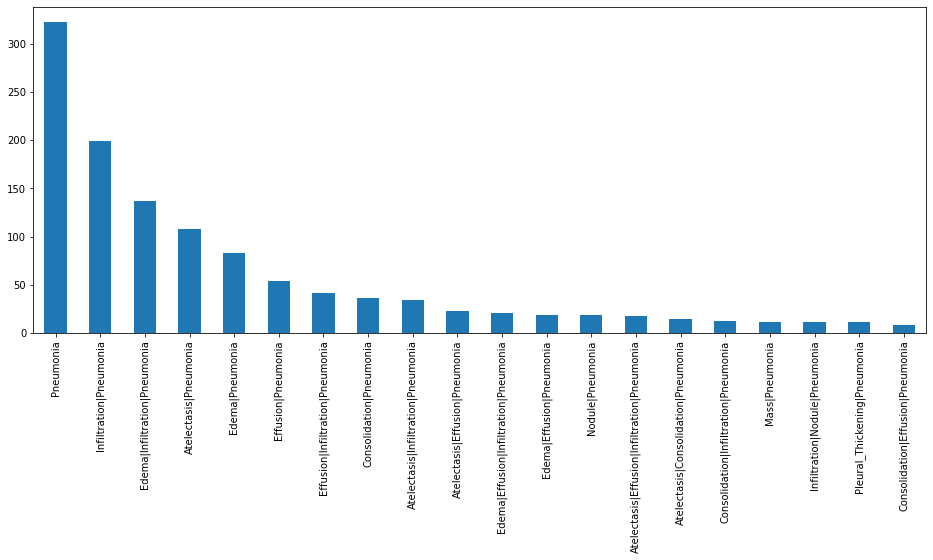

In [13]:
## Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
# First, set a condition(all_xray_df.pneumonia) for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')


The 30 most common concurrent disease with pneumonia are shown. Infilteration, Effusion and Atectasis being the most common concurrences.

### 2. Basic demographics

**2.1 Gender distribution**

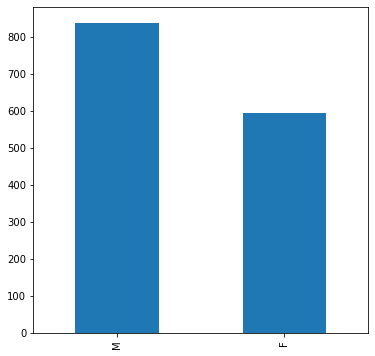

In [14]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

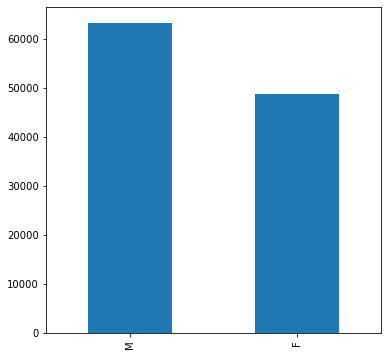

In [15]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

The number males in the test were marginally more than that of females by ratio 3:2. This ration remain consistent in the overal dataset and the pneumonia cohort

**2.2 Patient Age**

Text(0.5, 1.0, 'Ages group trained on')

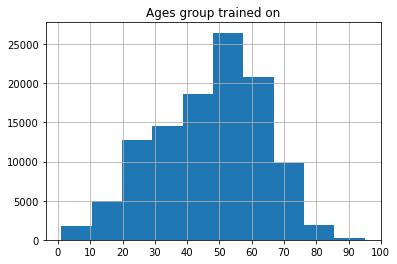

In [16]:
# Patient demographic data- my algorithm was trained on
#plt.figure(figsize=(10,6))
# First, set a condition(all_xray_df['Patient Age'] <100 for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot 
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'].hist(bins=10)
plt.xticks(list(range(0,101,10)))
plt.title('Ages group trained on')


The device was trained on people of age below 80 years.

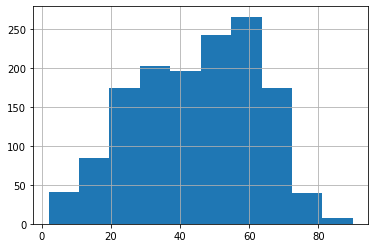

In [17]:
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'][all_xray_df.Pneumonia ==1].hist(bins=10)

**2.4 Age distribution for Pneumonia cases only**

This graph show that 50- 60 years age group most affected by pneumonia

**2.3 View Position of chest x ray with Pneumonia**

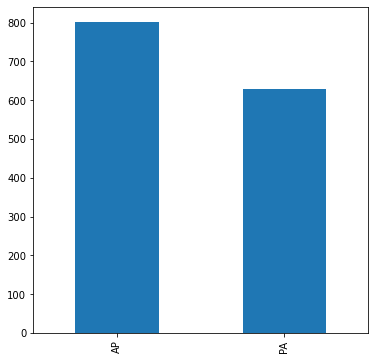

In [18]:
# Patient Position distribution of Pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')


There were more chest x-ray AP than PA views with people who have pneumonia

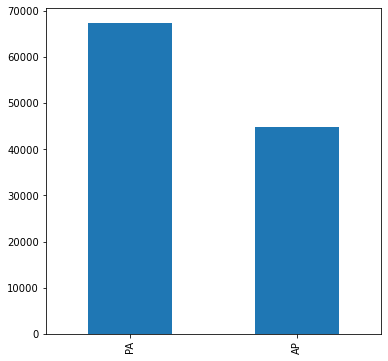

In [19]:
#  Patient position distribution of the dataset
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')


PA chest X-rays are are common than than AP views in this dataset.

### Number of concurrent disease with pneumonia

In [20]:
comorb = pd.read_csv('comorbidity.csv')

In [21]:
comorb.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,ground_truth,comorbidity
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,2.0
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0


In [22]:
# Create data I will use for my plot
comorb[comorb.Pneumonia==1]['comorbidity'].value_counts()

1.0    651
0.0    465
2.0    249
3.0     56
4.0      8
5.0      2
Name: comorbidity, dtype: int64

In [23]:
# Sort them into order and get the values
comorb_count= comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index()
y =comorb_count.values
y

array([465, 651, 249,  56,   8,   2])

In [24]:
# Call index values here
x = comorb_count.index
x

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

In [25]:
# Sort the index Index for x axis

comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index().index


Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

Text(0, 0.5, 'num_of_patients')

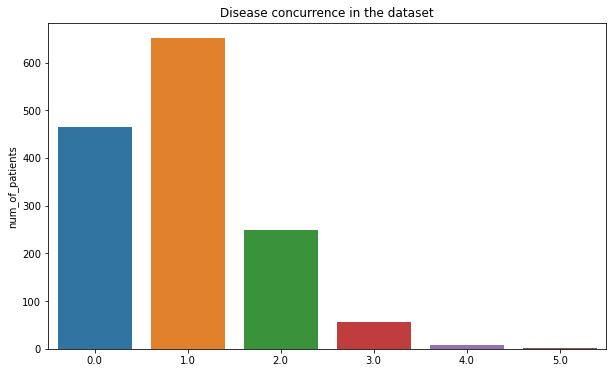

In [26]:
# Set the width and height of the figure
plt.figure(figsize=(10, 6))

# Add title
plt.title('Disease concurrence in the dataset')

# The comorbidity column is used to indentify the x axis and index for the y axis
sns.barplot(x=comorb_count.index, y=comorb_count.values)


plt.ylabel('num_of_patients')


50% of the patients had no concurrent disease. 

### Pixel-level data Analysis

In [27]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5571,00030419_001.png,Cardiomegaly|Effusion,1,30419,012Y,M,AP,3056,2544,0.139,0.139
3204,00015756_004.png,No Finding,4,15756,057Y,M,AP,2500,2048,0.168,0.168
1052,00005496_000.png,No Finding,0,5496,026Y,F,PA,2500,2048,0.171,0.171


In [28]:
# Create paths to images and assign it to the variable paths

# x represent image index
paths = {os.path.basename(x): x for x in glob(os.path.join('/data/','images*/','images/', '*.png'))}

# Create a column path and populate it by mapping panda series index to thier image path
sample_df['path'] = sample_df['Image Index'].map(paths.get)
# Random sample of 3 images
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2948,00014475_000.png,No Finding,0,14475,036Y,F,PA,2992,2991,0.143,0.143,/data/images_007/images/00014475_000.png
2471,00012428_003.png,No Finding,3,12428,062Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00012428_003.png
1032,00005400_006.png,Infiltration,6,5400,035Y,M,AP,2500,2048,0.171,0.171,/data/images_003/images/00005400_006.png


### 1. Assess disease pixel intensity
The focus is on the pixel intensity of pneumonia and the most frequent disease concurrences of pneumonia

**1.1 Plot Pneumonia Intensity**

In [29]:
hist = sample_df[sample_df["Finding Labels"].str.match('Pneumonia')]
data = []
# For index of p in range 9
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]["path"]))

In [30]:
data

[('pneumonia', '/data/images_004/images/00008470_008.png'),
 ('pneumonia', '/data/images_006/images/00011702_043.png'),
 ('pneumonia', '/data/images_006/images/00012158_025.png'),
 ('pneumonia', '/data/images_006/images/00012667_000.png'),
 ('pneumonia', '/data/images_006/images/00012733_000.png'),
 ('pneumonia', '/data/images_007/images/00014201_008.png'),
 ('pneumonia', '/data/images_008/images/00017714_019.png'),
 ('pneumonia', '/data/images_009/images/00019021_001.png'),
 ('pneumonia', '/data/images_009/images/00019865_013.png')]

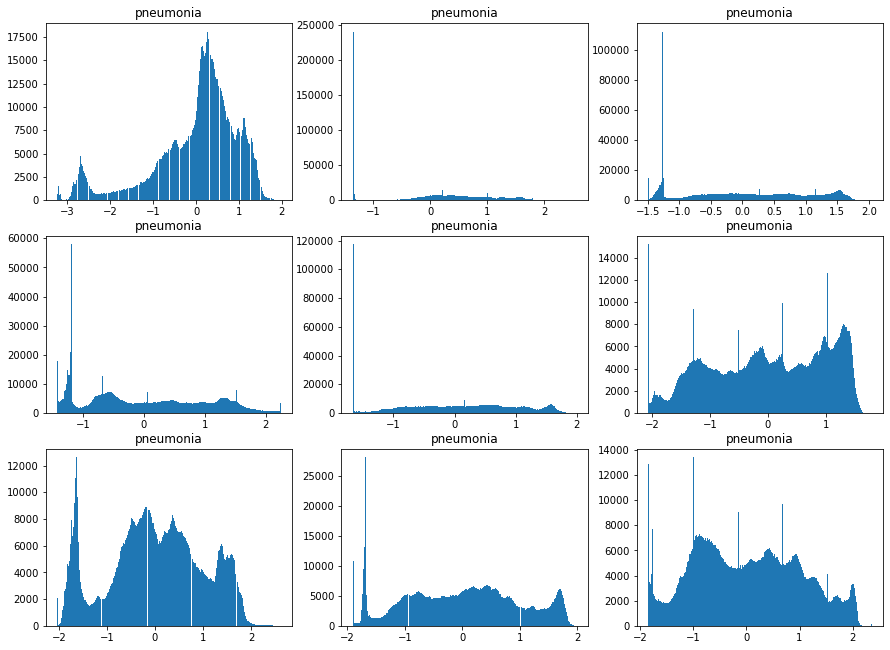

In [31]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

What does this tell us? It tell us that the intensity values of the mass are higher than the image mean, but mostly fall within a single standard deviation of the image intensity values. This tell us that using some sort of thresholding mechanism to identify tumors in an image would probably _not_ be appropriate, because the mass's intensity values are not _that_ different from the rest of the image. 

**1.2 Plot Infiltration intensity**

In [32]:
# Create a new dataframe and assign it to variable hist
hist = sample_df[sample_df["Finding Labels"].str.match('Infiltration')]


# Create an empty data list for the plot
data = []
# For index of p in range 9
for p in range(9):
    data.append(("infiltration", hist.iloc[p]["path"]))


In [33]:
data

[('infiltration', '/data/images_001/images/00000154_001.png'),
 ('infiltration', '/data/images_001/images/00000181_017.png'),
 ('infiltration', '/data/images_001/images/00000181_035.png'),
 ('infiltration', '/data/images_001/images/00000246_011.png'),
 ('infiltration', '/data/images_001/images/00000250_005.png'),
 ('infiltration', '/data/images_001/images/00000268_001.png'),
 ('infiltration', '/data/images_001/images/00000324_001.png'),
 ('infiltration', '/data/images_001/images/00000360_008.png'),
 ('infiltration', '/data/images_001/images/00000459_037.png')]

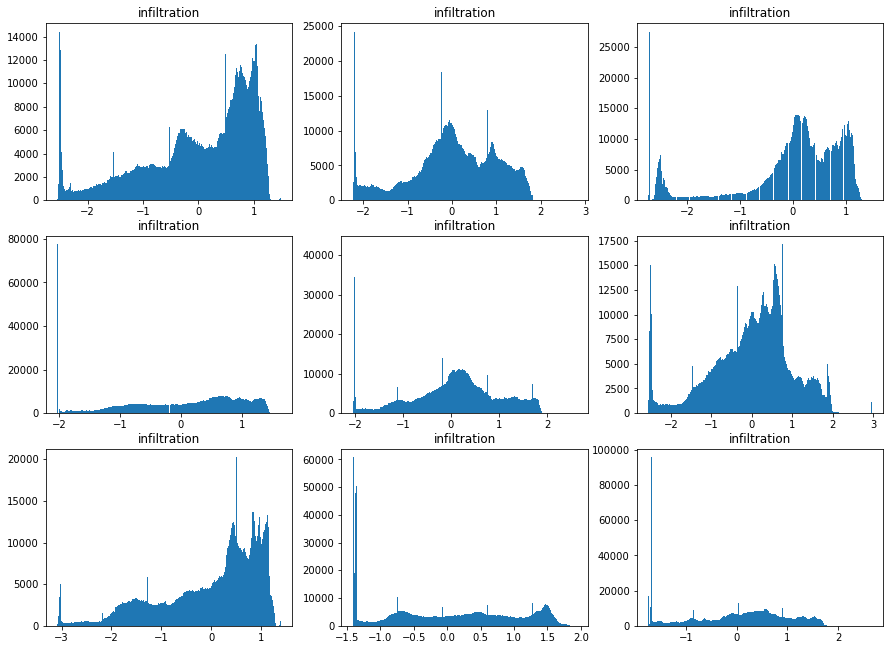

In [34]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('infiltration')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

**1.3 Plot effusion intensity**

In [35]:
# 
hist = sample_df[sample_df["Finding Labels"].str.match('Effusion')]
data = []
# For index of p in range 9
for p in range(9):
    data.append(("effusion", hist.iloc[p]["path"]))

In [36]:
data

[('effusion', '/data/images_001/images/00000061_002.png'),
 ('effusion', '/data/images_001/images/00000084_000.png'),
 ('effusion', '/data/images_001/images/00000096_006.png'),
 ('effusion', '/data/images_001/images/00000099_003.png'),
 ('effusion', '/data/images_001/images/00000127_007.png'),
 ('effusion', '/data/images_001/images/00000545_000.png'),
 ('effusion', '/data/images_001/images/00000583_016.png'),
 ('effusion', '/data/images_001/images/00000632_011.png'),
 ('effusion', '/data/images_001/images/00000742_000.png')]

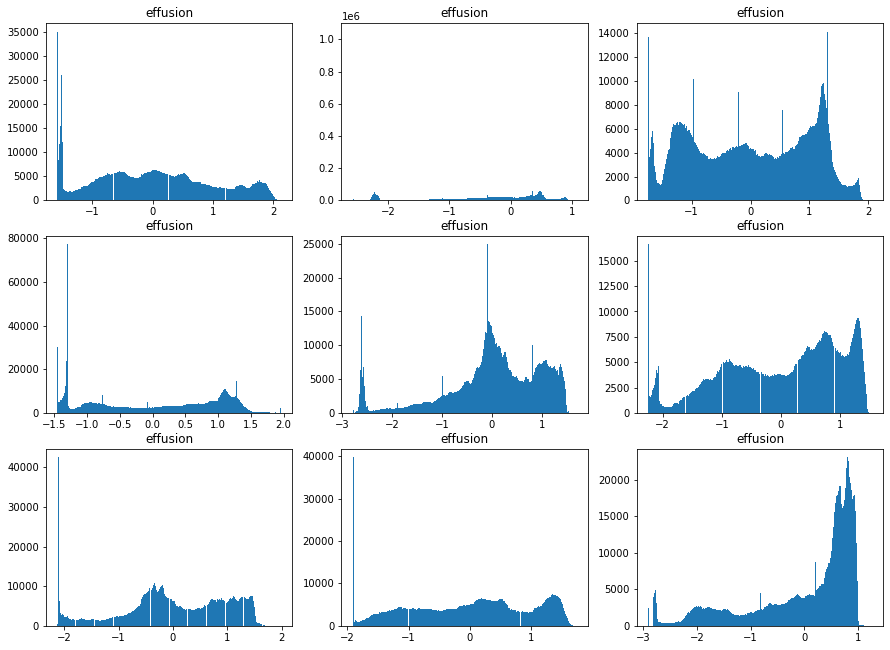

In [37]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('effusion')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)
    

**1.4 Plot atelectasis pixel intensity**

In [38]:
# 
hist = sample_df[sample_df["Finding Labels"].str.match('Atelectasis')]
data = []
for p in range(9):
    # For index of p in range 9
    data.append(("atelectasis", hist.iloc[p]["path"]))

In [39]:
data

[('atelectasis', '/data/images_001/images/00000030_001.png'),
 ('atelectasis', '/data/images_001/images/00000175_001.png'),
 ('atelectasis', '/data/images_001/images/00000175_002.png'),
 ('atelectasis', '/data/images_001/images/00000248_020.png'),
 ('atelectasis', '/data/images_001/images/00000642_000.png'),
 ('atelectasis', '/data/images_001/images/00000816_000.png'),
 ('atelectasis', '/data/images_001/images/00000861_002.png'),
 ('atelectasis', '/data/images_001/images/00000938_004.png'),
 ('atelectasis', '/data/images_001/images/00000957_001.png')]

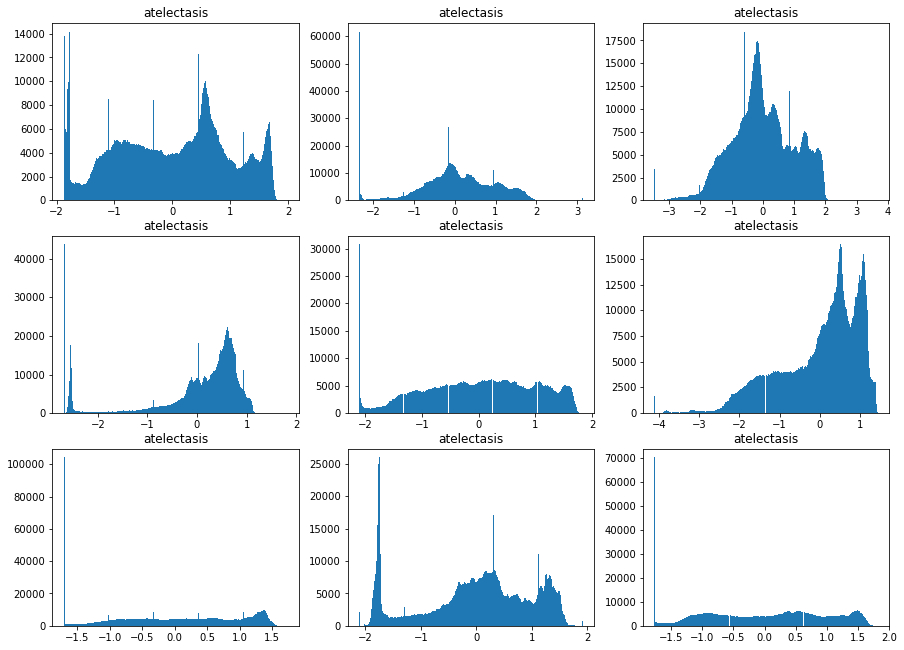

In [40]:
plt.figure(figsize=(15, 15))
columns = 3
# For index of p in range 9
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('atelectasis')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

**1.5 Plot Nodule pixel intensity**

In [41]:
# 
hist = sample_df[sample_df["Finding Labels"].str.match('Nodule')]
data = []
for p in range(9):
    # For index of p in range 9
    data.append(("nodule", hist.iloc[p]["path"]))

In [42]:
data

[('nodule', '/data/images_001/images/00000556_000.png'),
 ('nodule', '/data/images_001/images/00000569_005.png'),
 ('nodule', '/data/images_001/images/00000954_005.png'),
 ('nodule', '/data/images_001/images/00001248_005.png'),
 ('nodule', '/data/images_002/images/00001836_100.png'),
 ('nodule', '/data/images_002/images/00001974_011.png'),
 ('nodule', '/data/images_002/images/00002066_014.png'),
 ('nodule', '/data/images_002/images/00002345_000.png'),
 ('nodule', '/data/images_002/images/00002716_000.png')]

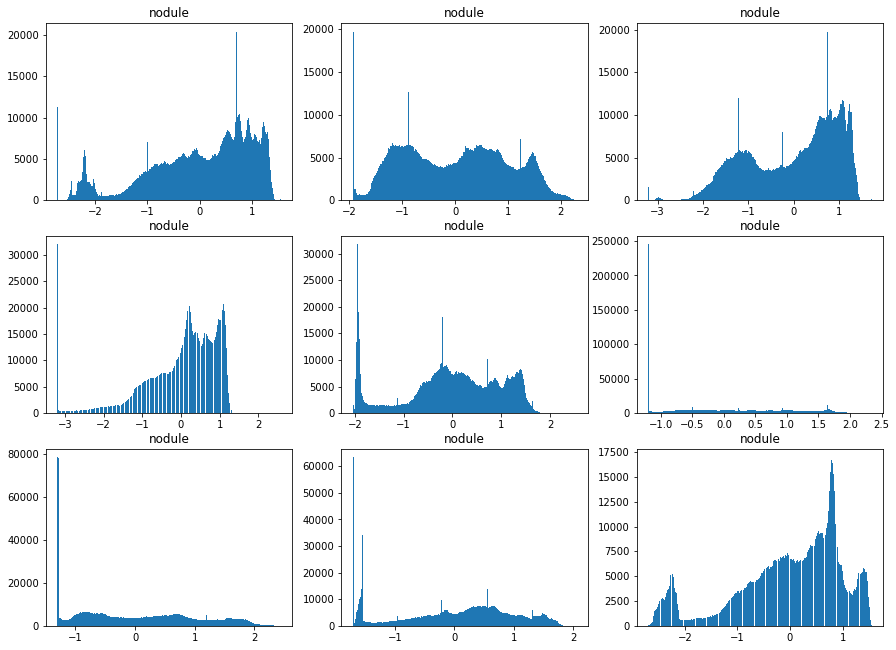

In [43]:
plt.figure(figsize=(15, 15))
columns = 3
# For index of path in range 9
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('nodule')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

**1.6 Plot Pneumothorax pixel intensity**

In [44]:
# 
hist = sample_df[sample_df["Finding Labels"].str.match('Pneumothorax')]
data = []
# For index of path in range 9
for p in range(9):
    data.append(("pneumothorax", hist.iloc[p]["path"]))

In [45]:
data

[('pneumothorax', '/data/images_001/images/00000118_011.png'),
 ('pneumothorax', '/data/images_001/images/00000372_002.png'),
 ('pneumothorax', '/data/images_001/images/00000467_013.png'),
 ('pneumothorax', '/data/images_001/images/00000832_005.png'),
 ('pneumothorax', '/data/images_002/images/00001968_000.png'),
 ('pneumothorax', '/data/images_002/images/00001972_001.png'),
 ('pneumothorax', '/data/images_002/images/00002046_003.png'),
 ('pneumothorax', '/data/images_002/images/00002106_001.png'),
 ('pneumothorax', '/data/images_002/images/00002290_003.png')]

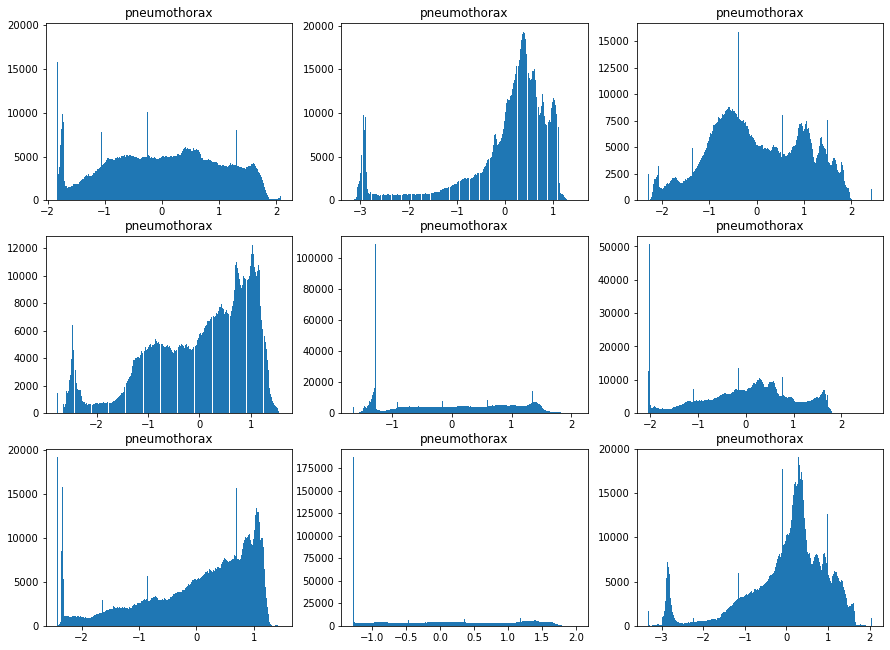

In [46]:
plt.figure(figsize=(15, 15))
columns = 3
# For index of path in range 9
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumothorax')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

### A list of labels from samples.csv

In [47]:
## Here I'm just going to split up my "Finding Labels" column by the | symbol separator 
# so that I have one column per disease in my dataframe,
# with a binary flag. This makes EDA a lot easier! 

# maps/gets each row of the Finding label column and split it using the '|' character as separable. 
labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('All Labels ({}): {}'.format(len(labels), labels))
for label in labels:
    if len(label)>1: # leave out empty labels
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [48]:

labels


['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


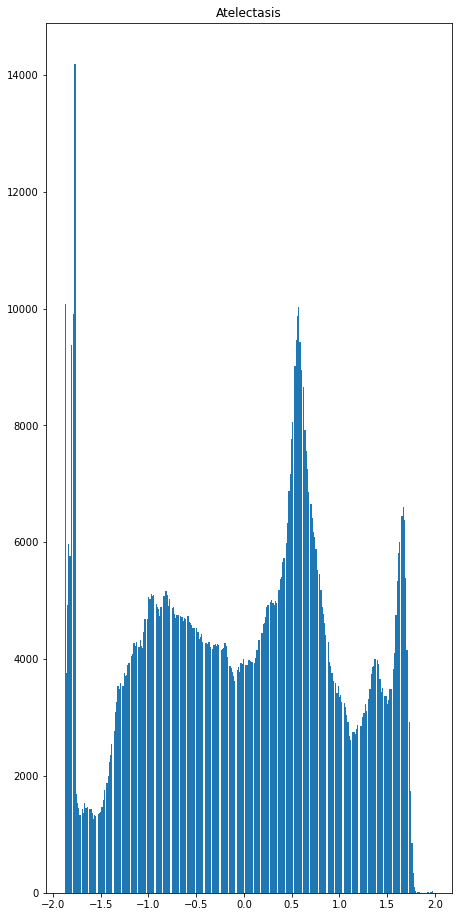

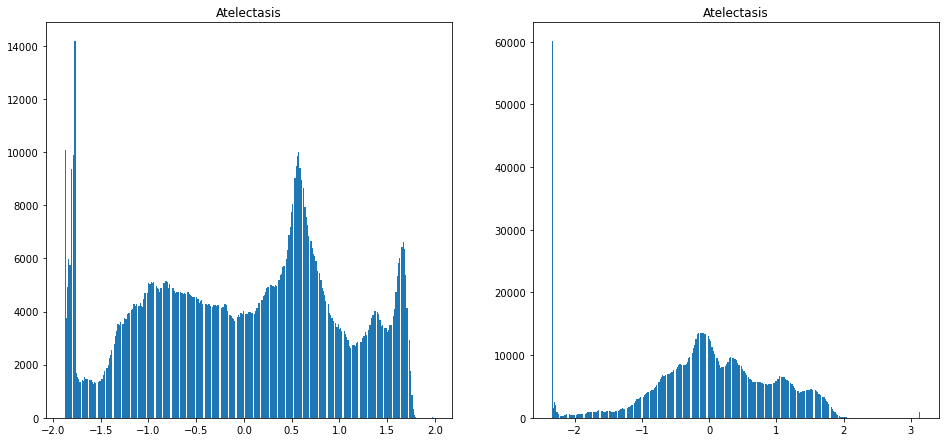

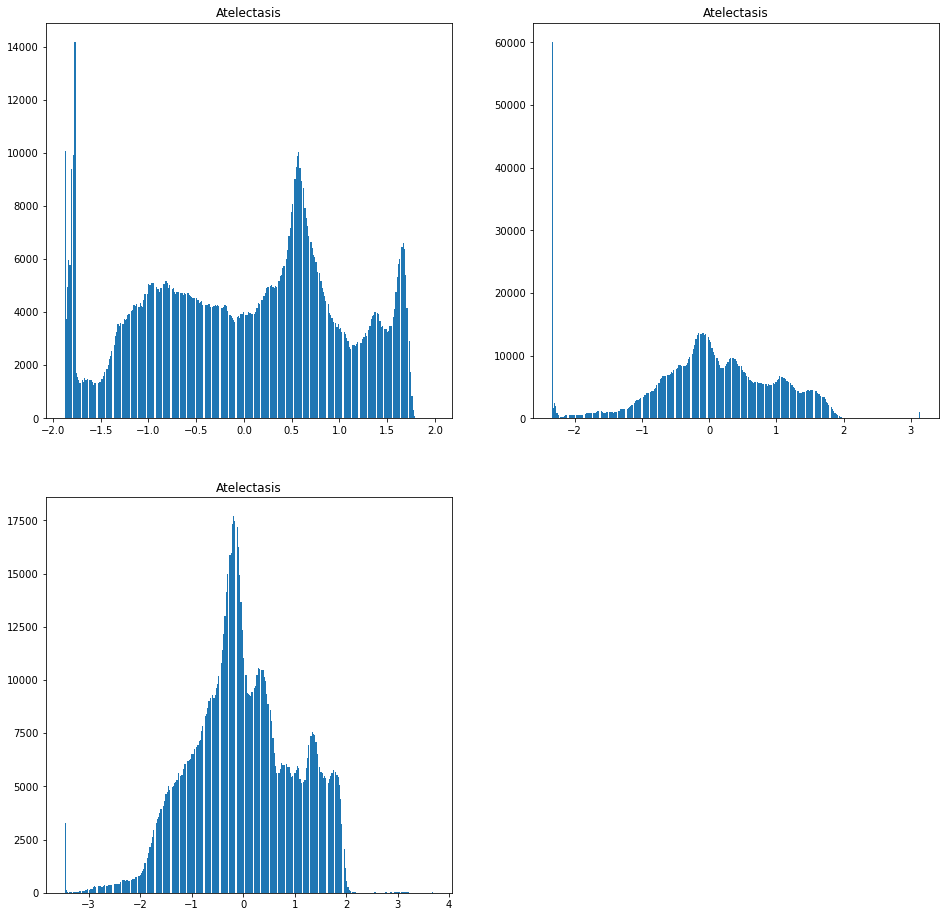

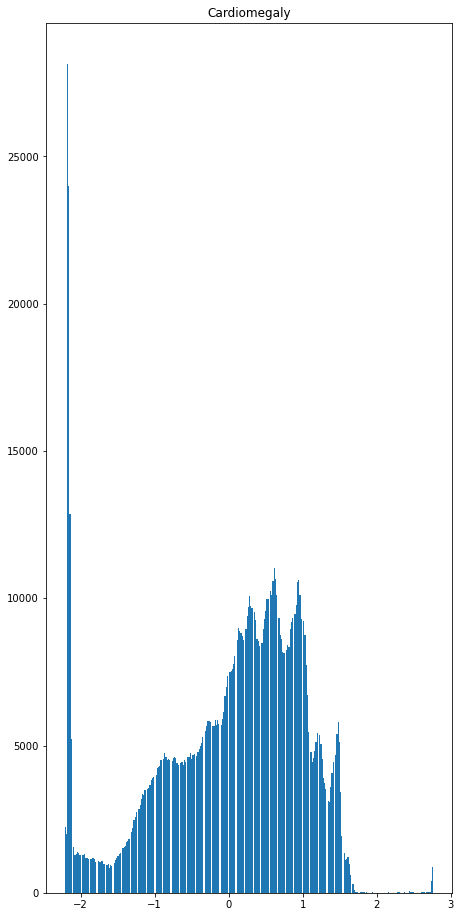

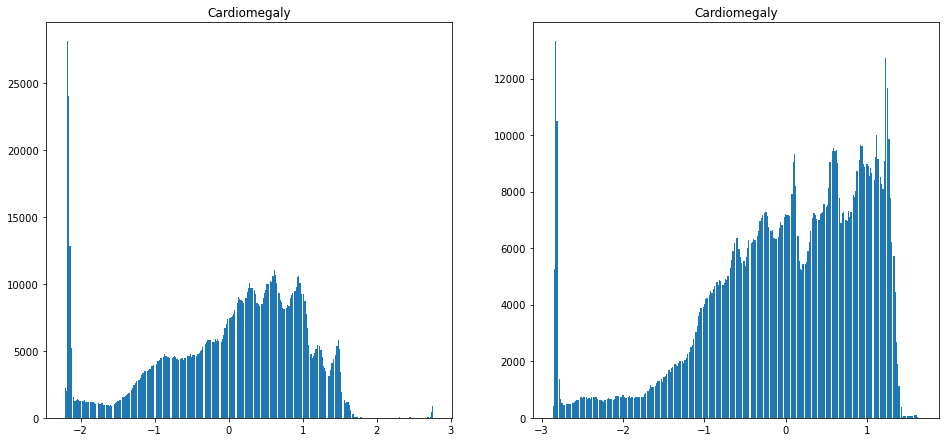

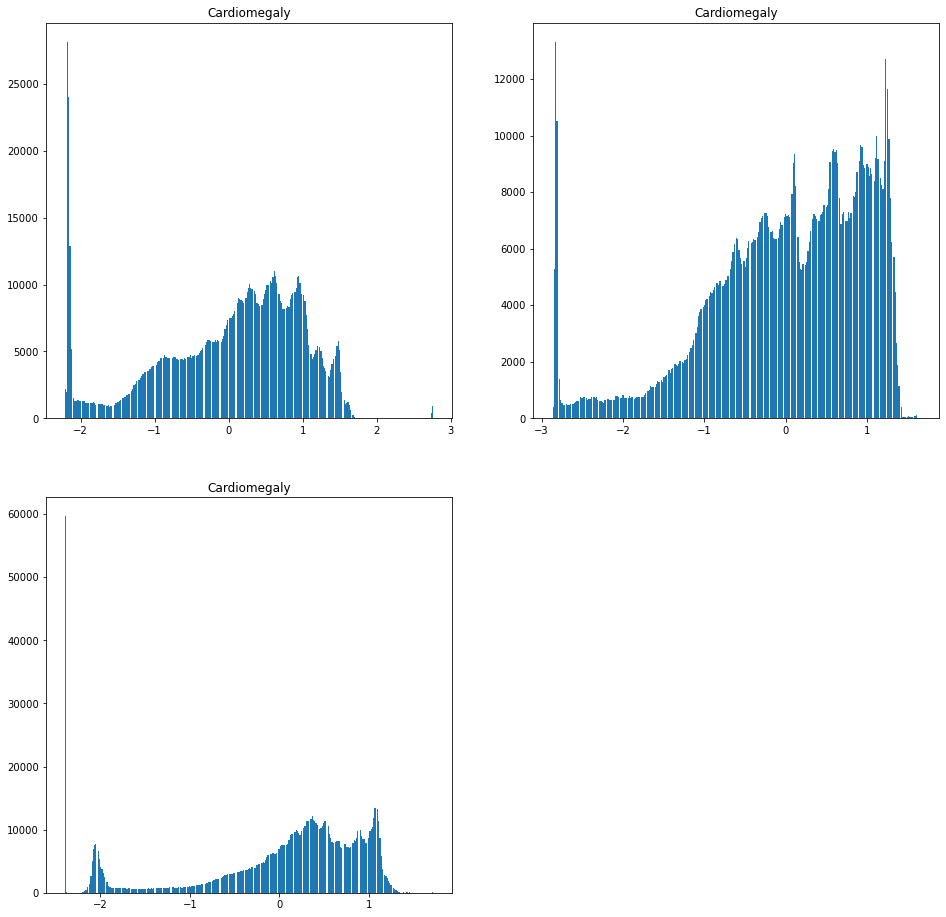

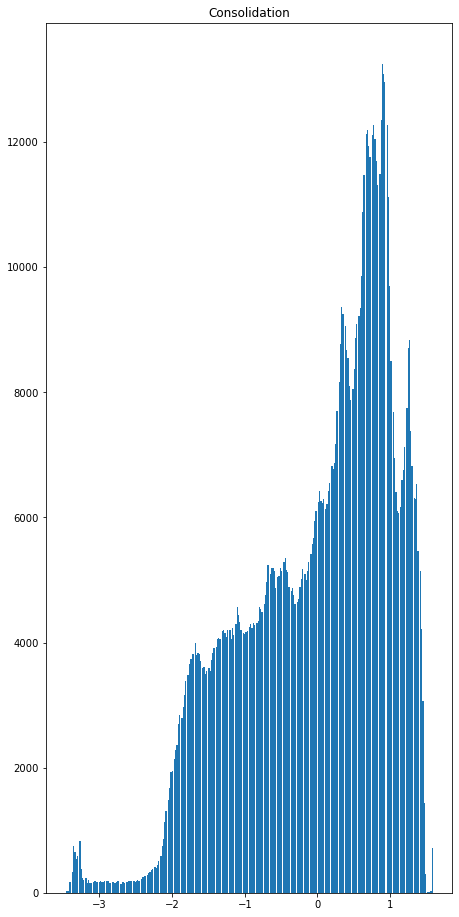

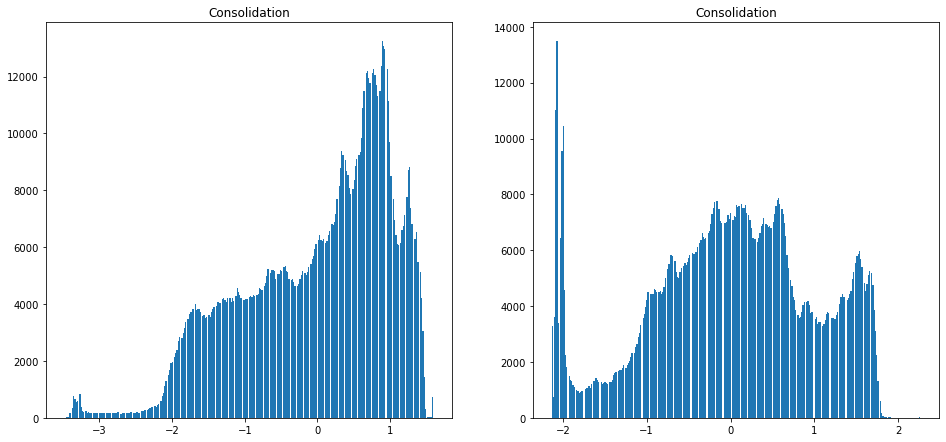

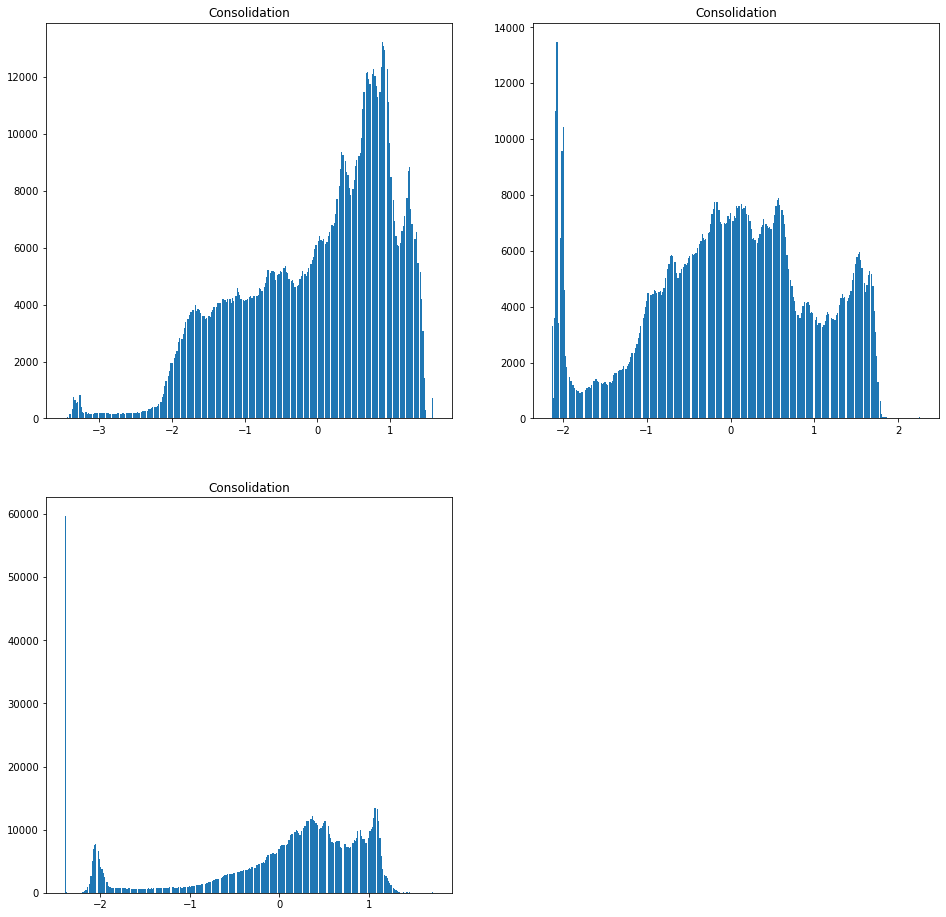

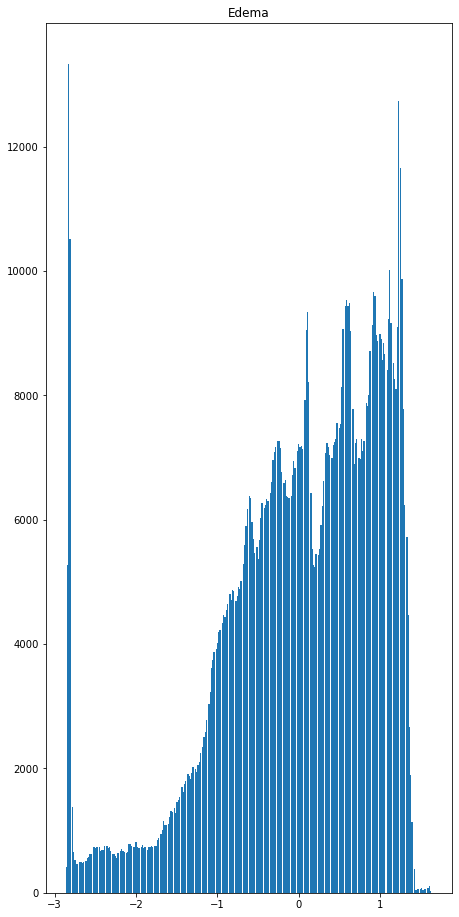

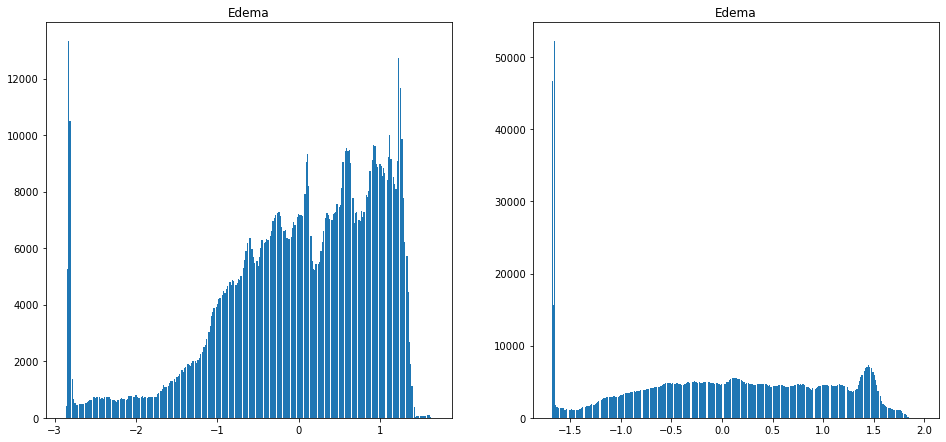

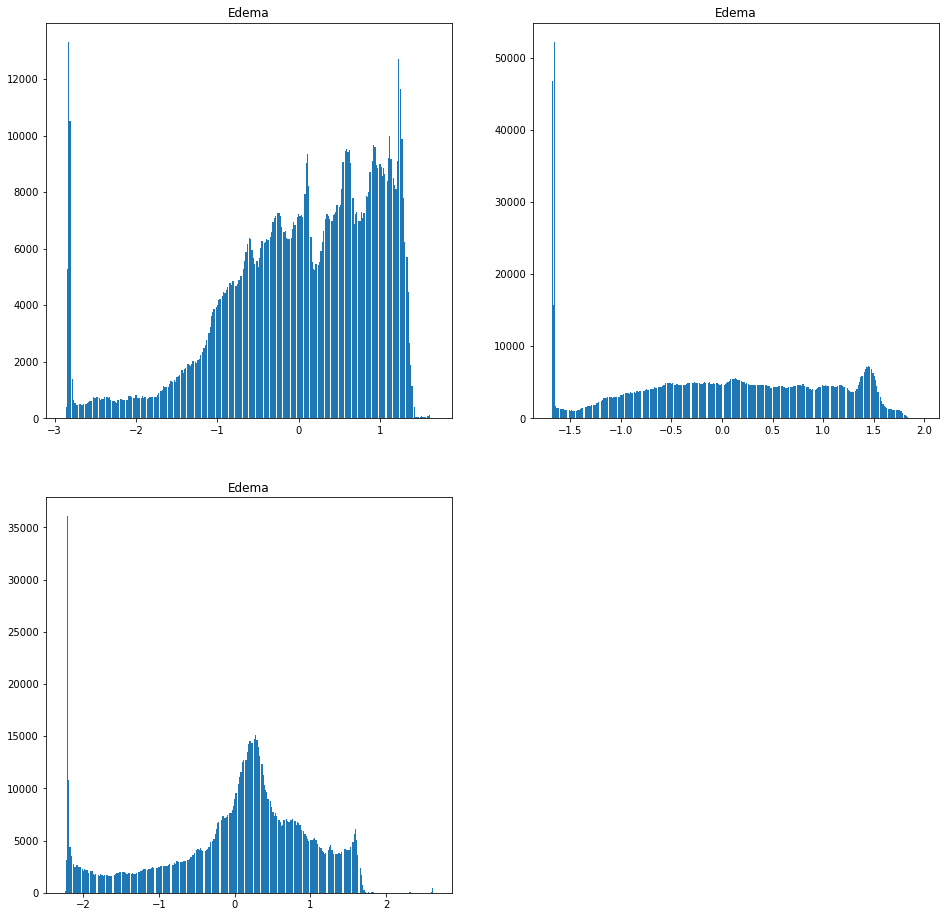

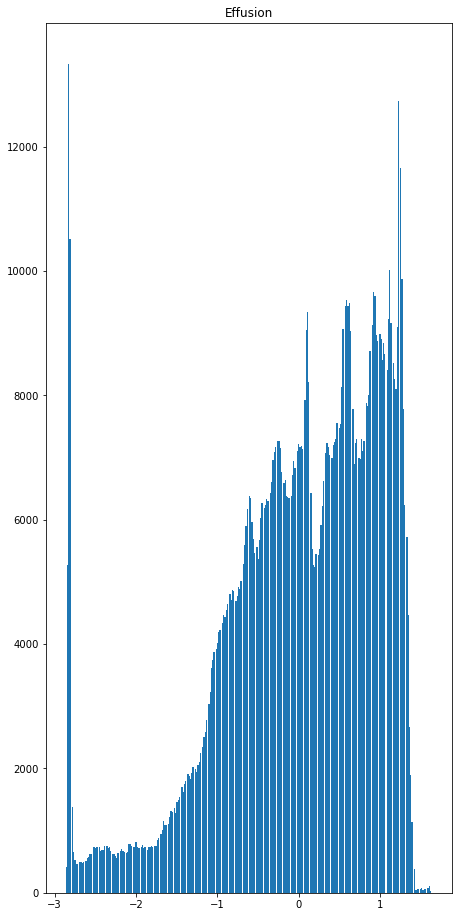

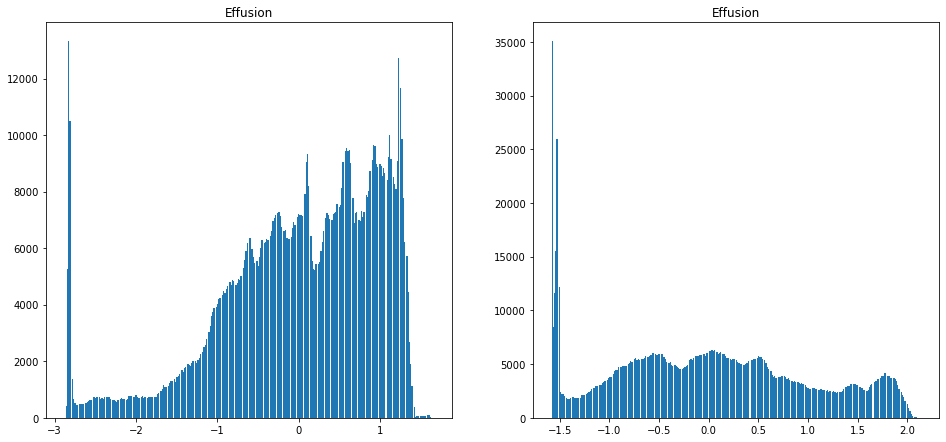

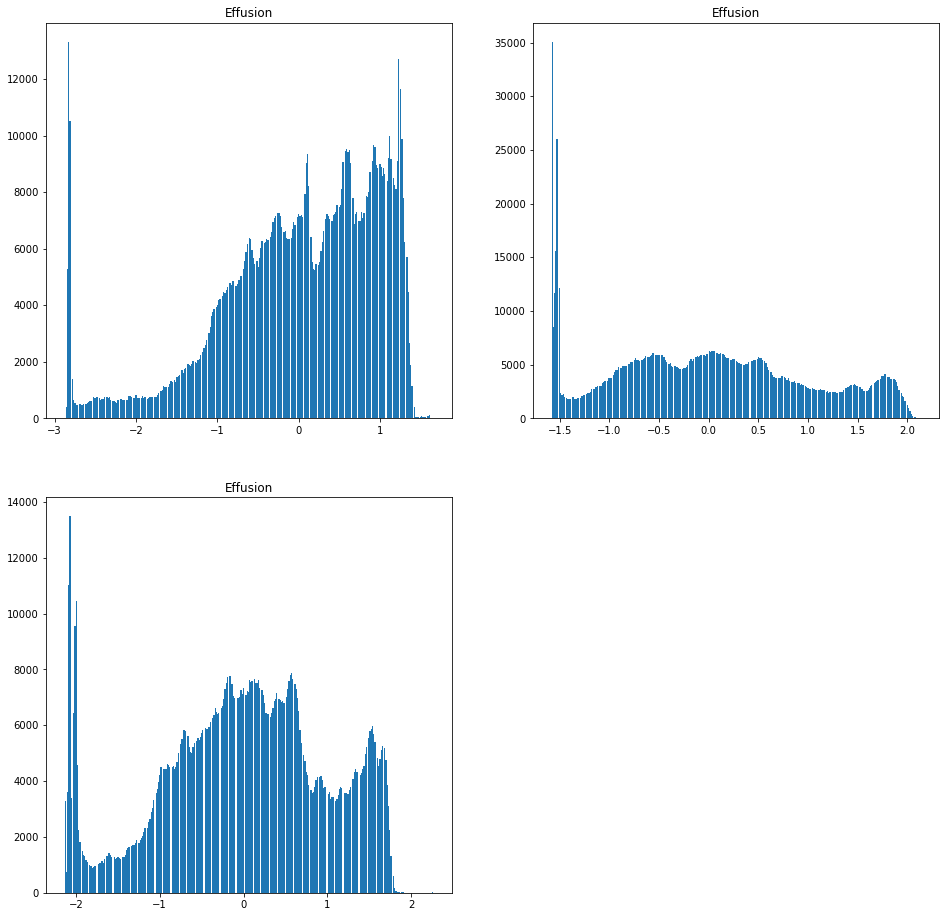

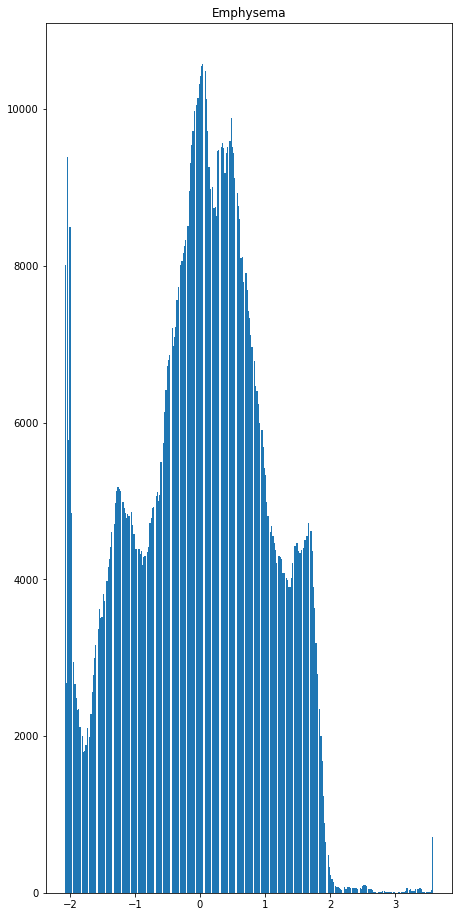

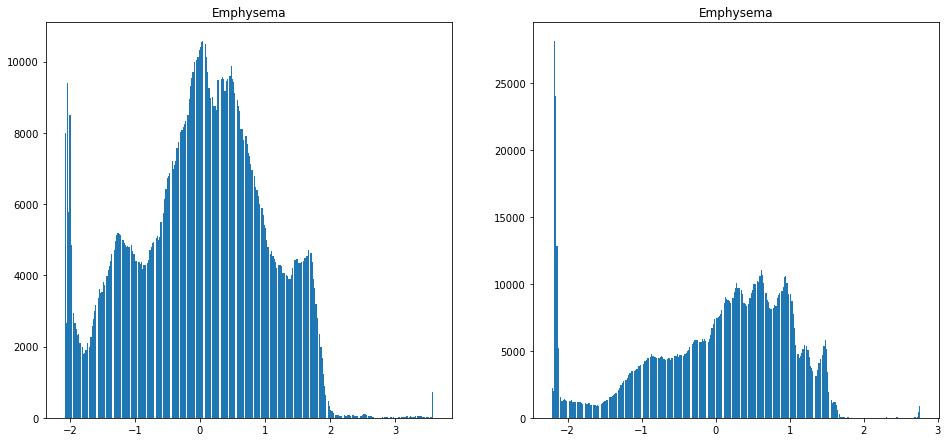

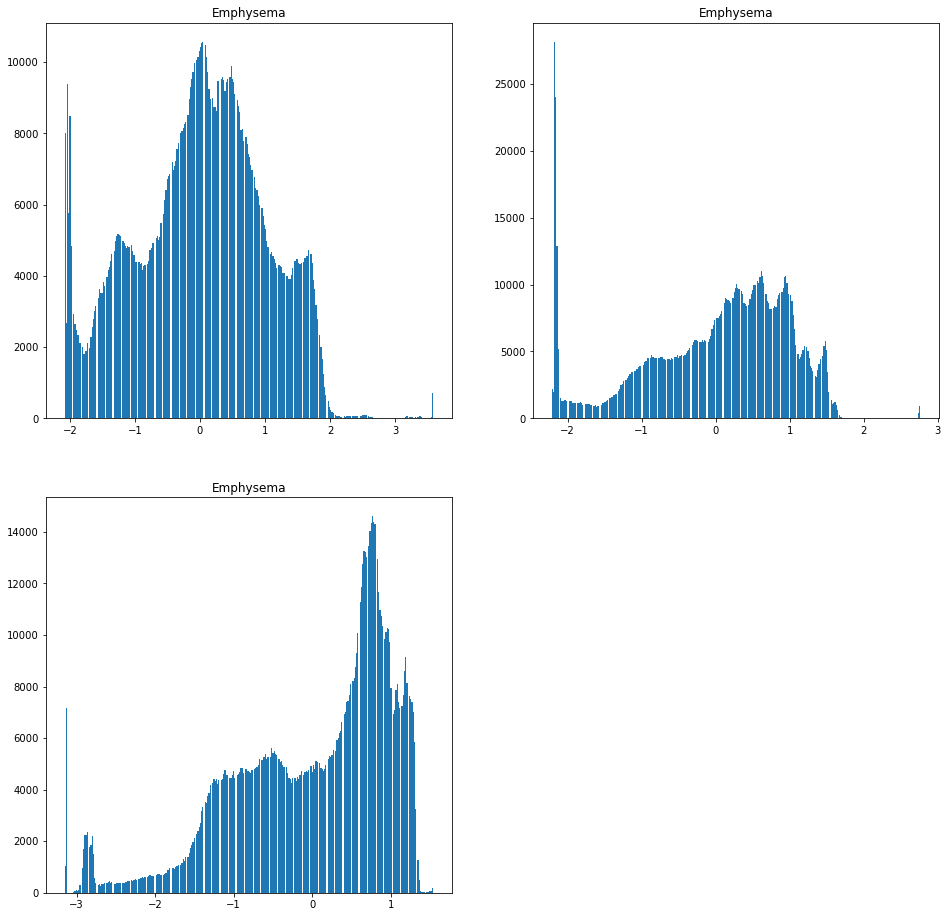

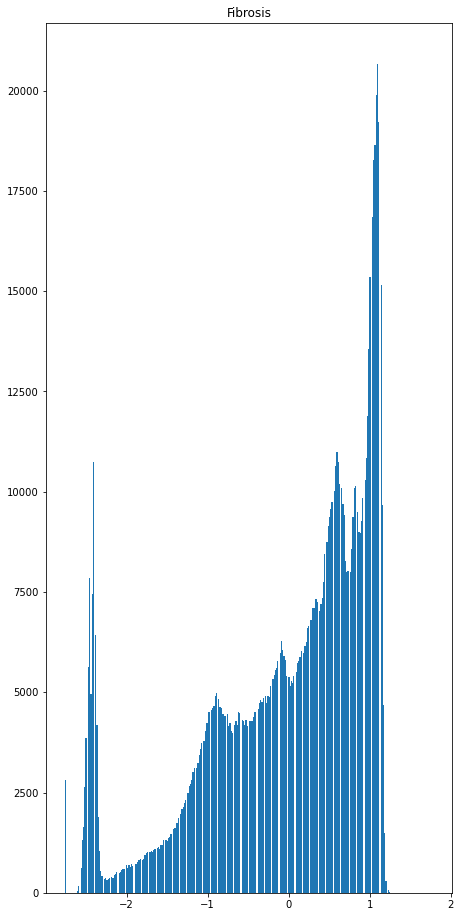

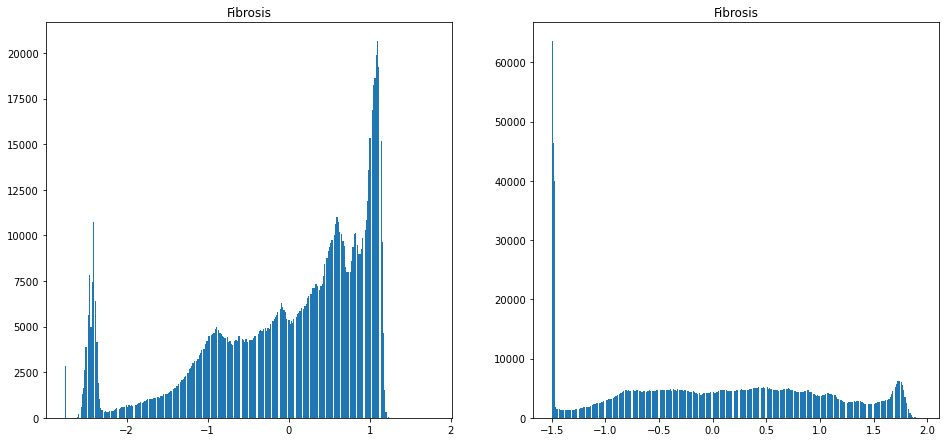

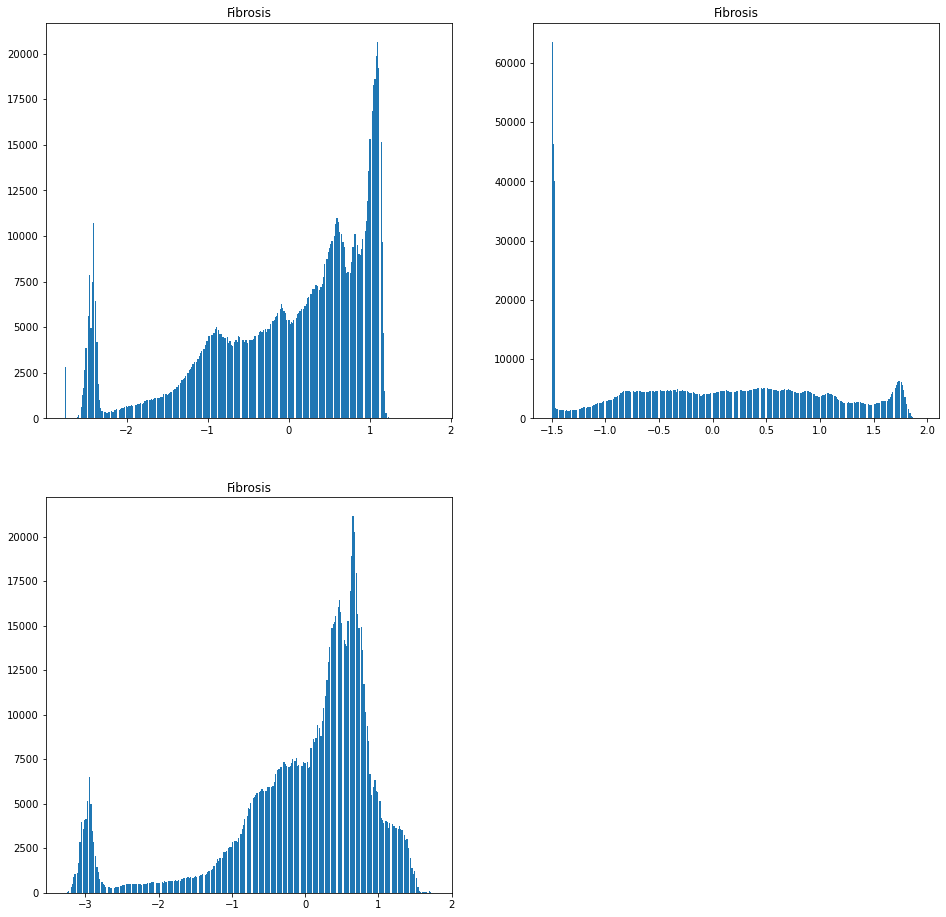

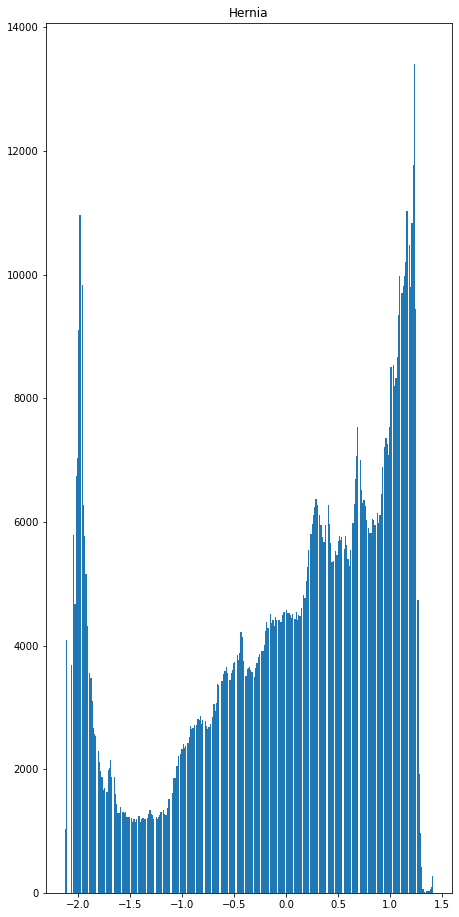

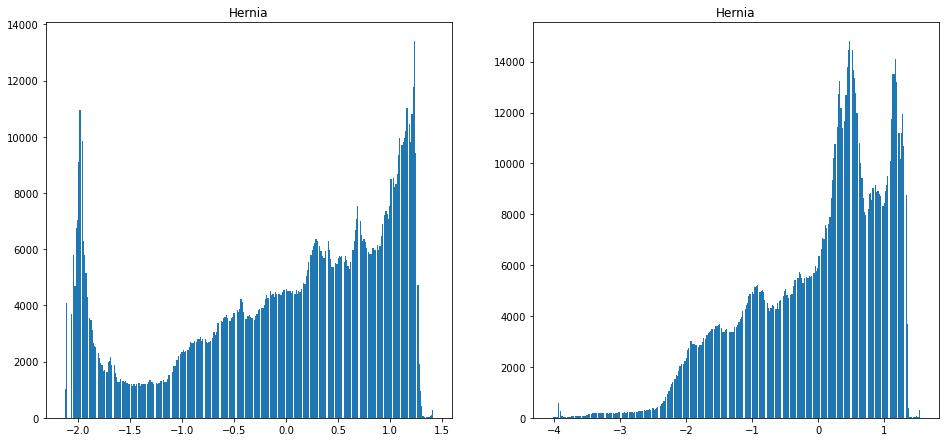

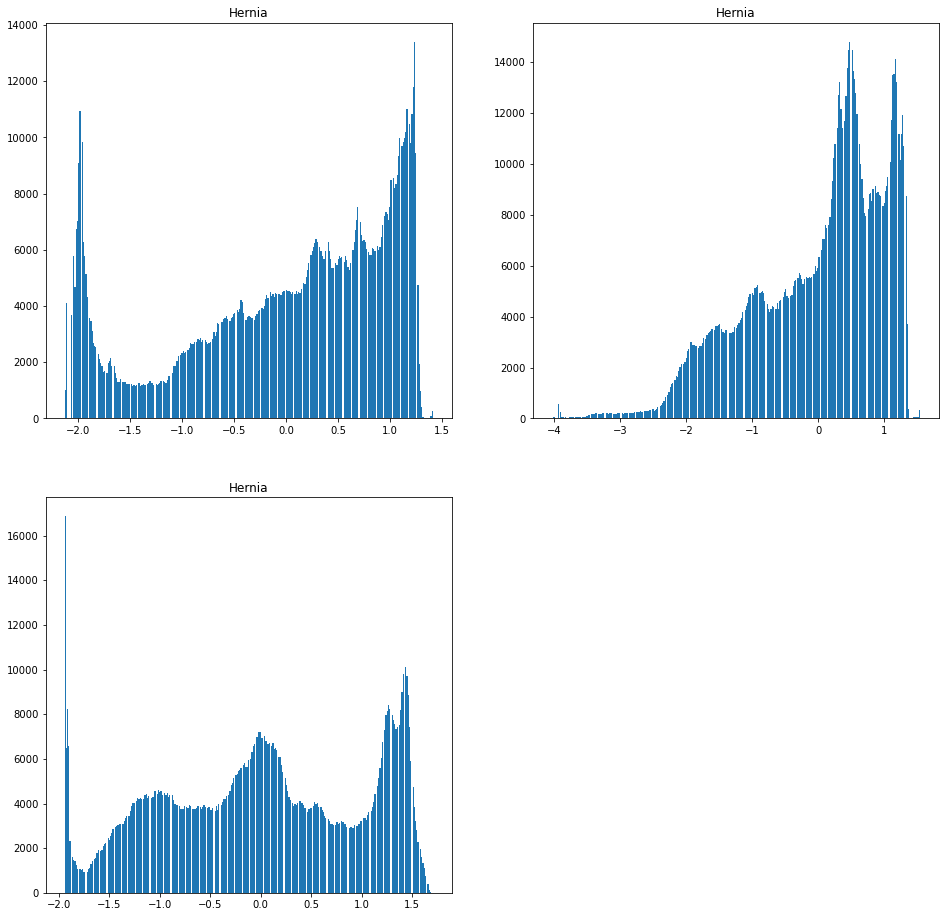

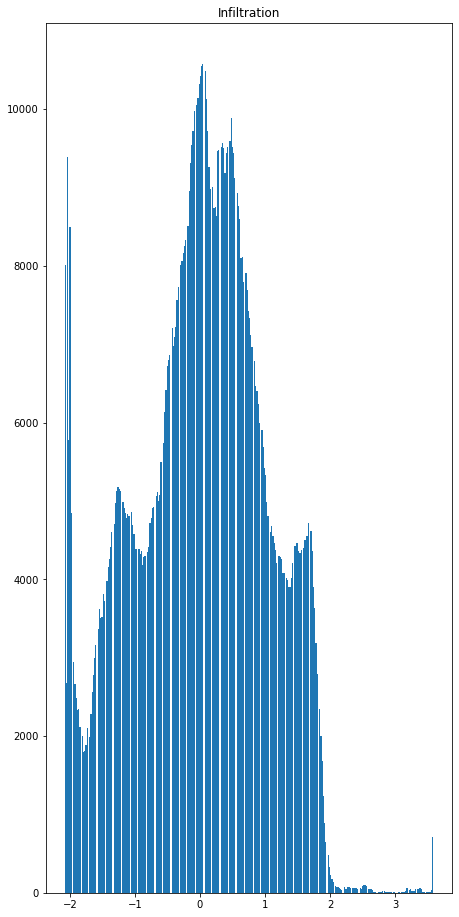

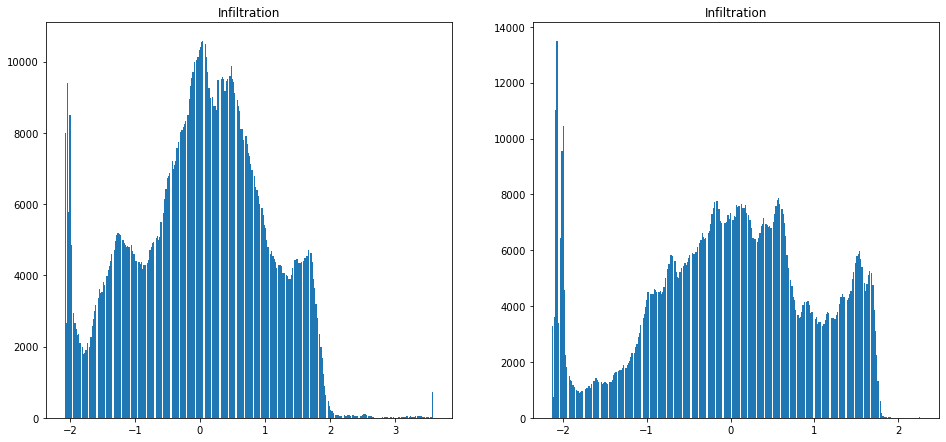

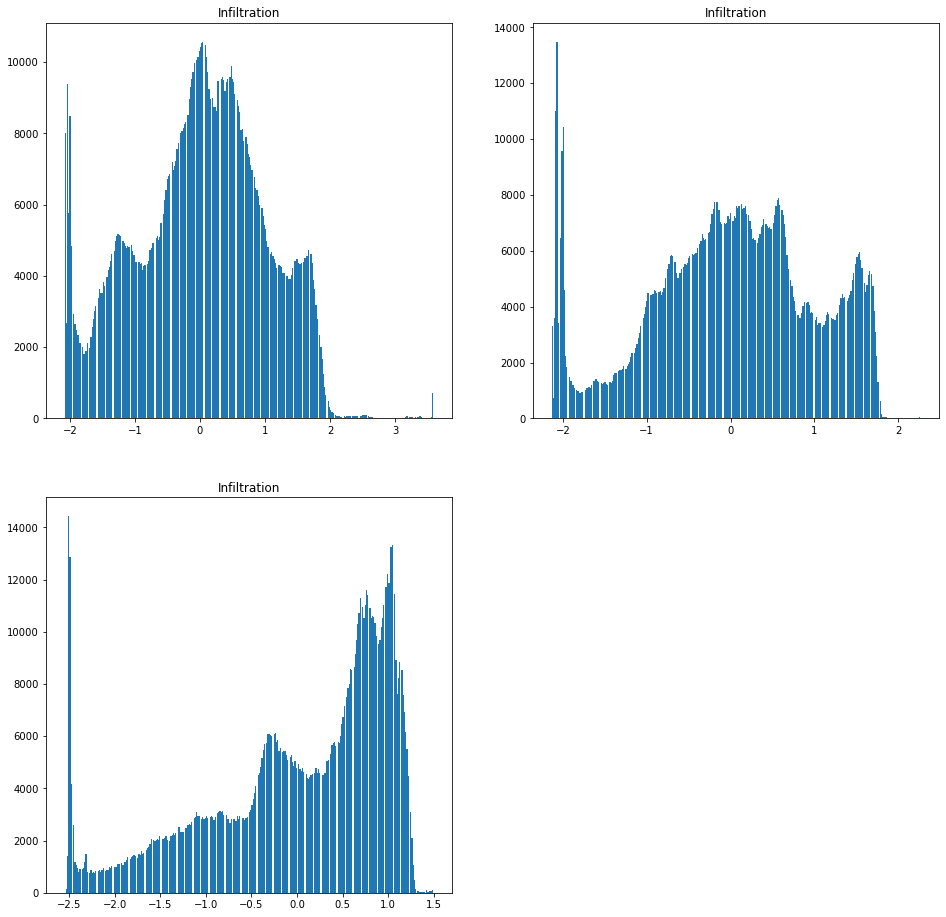

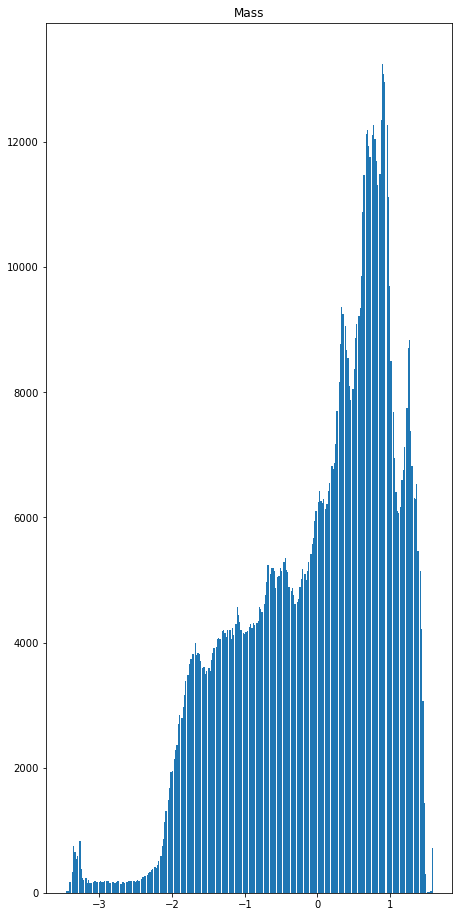

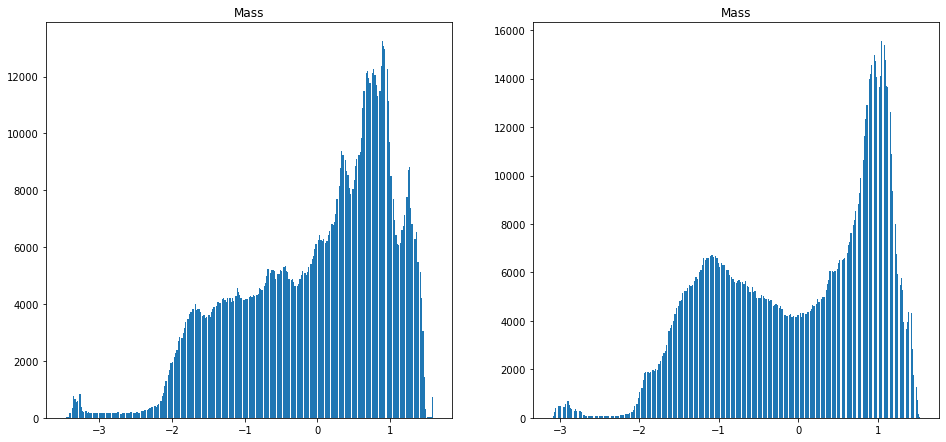

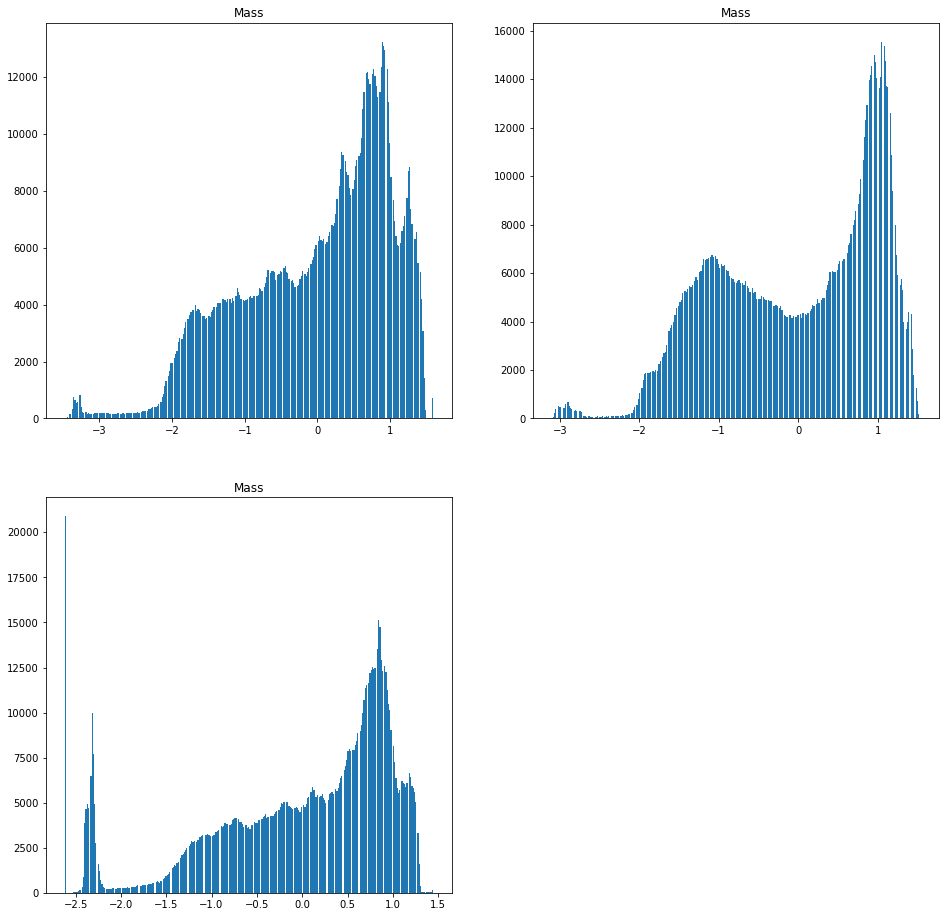

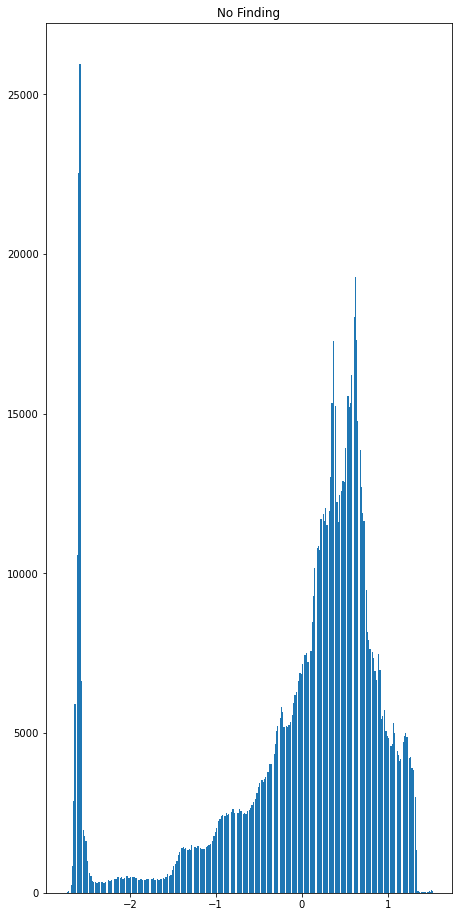

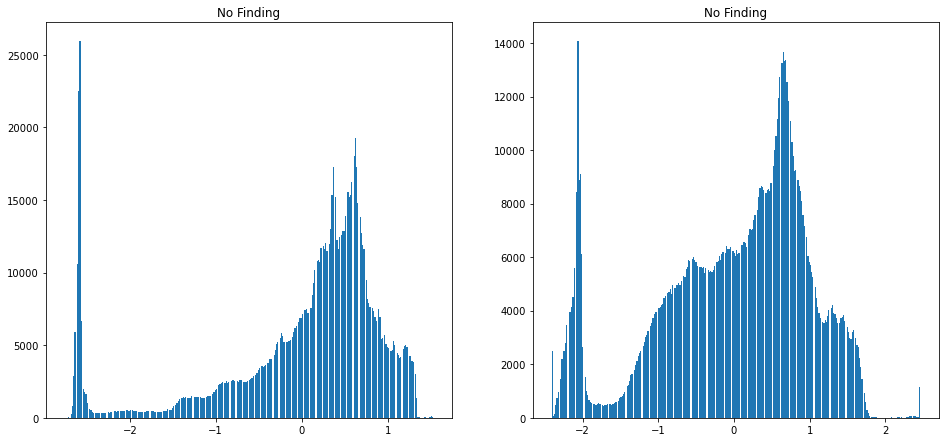

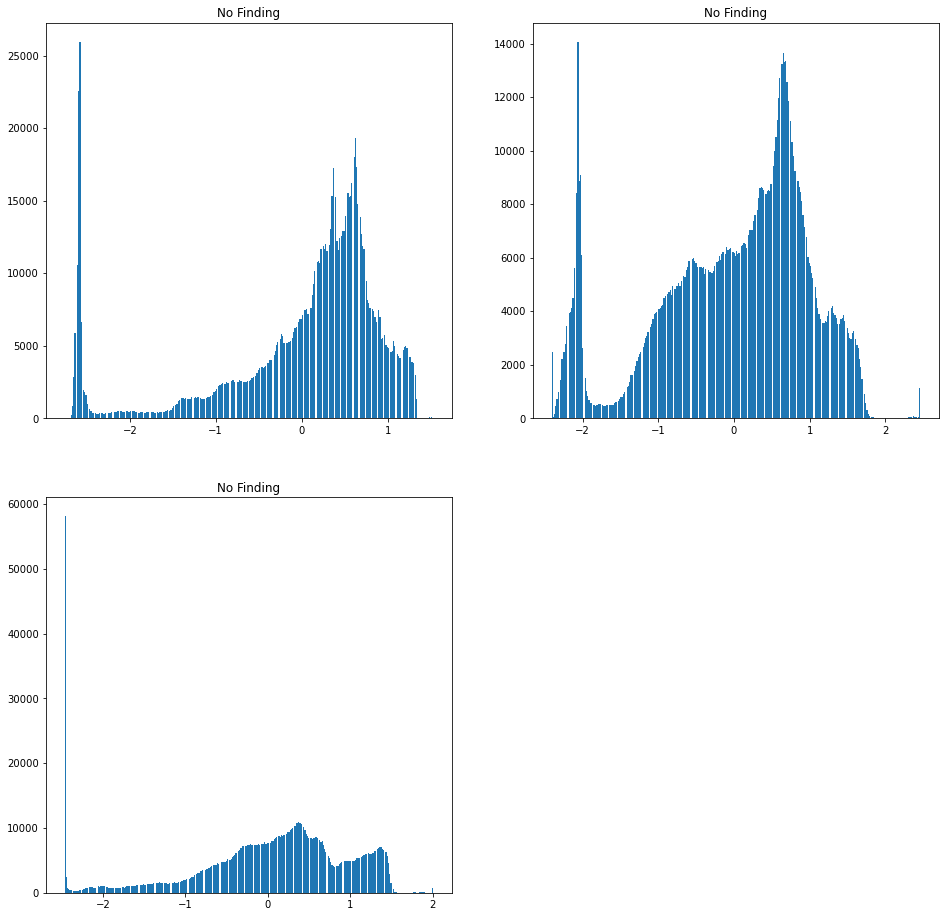

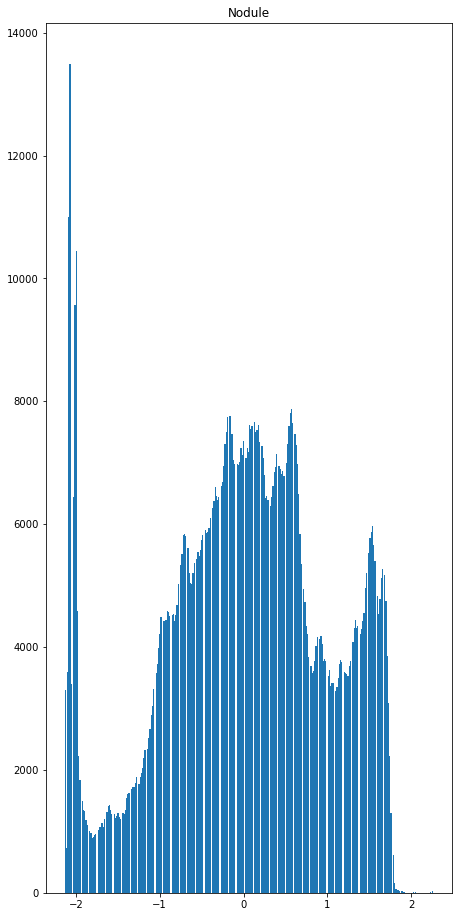

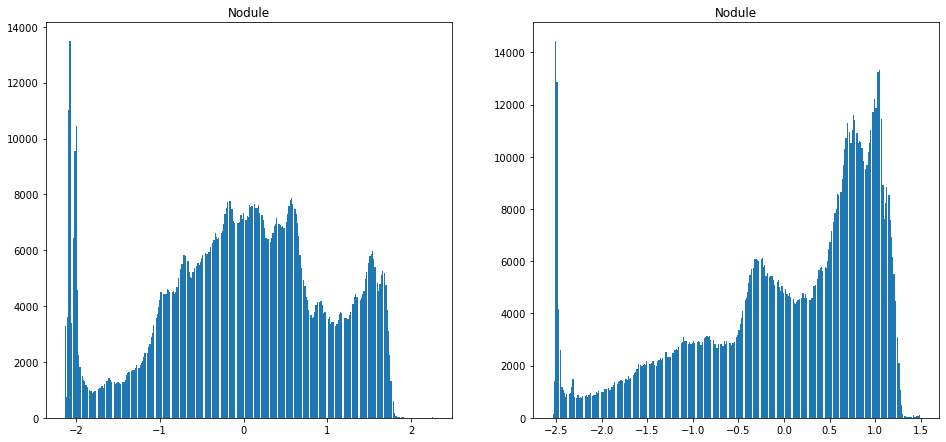

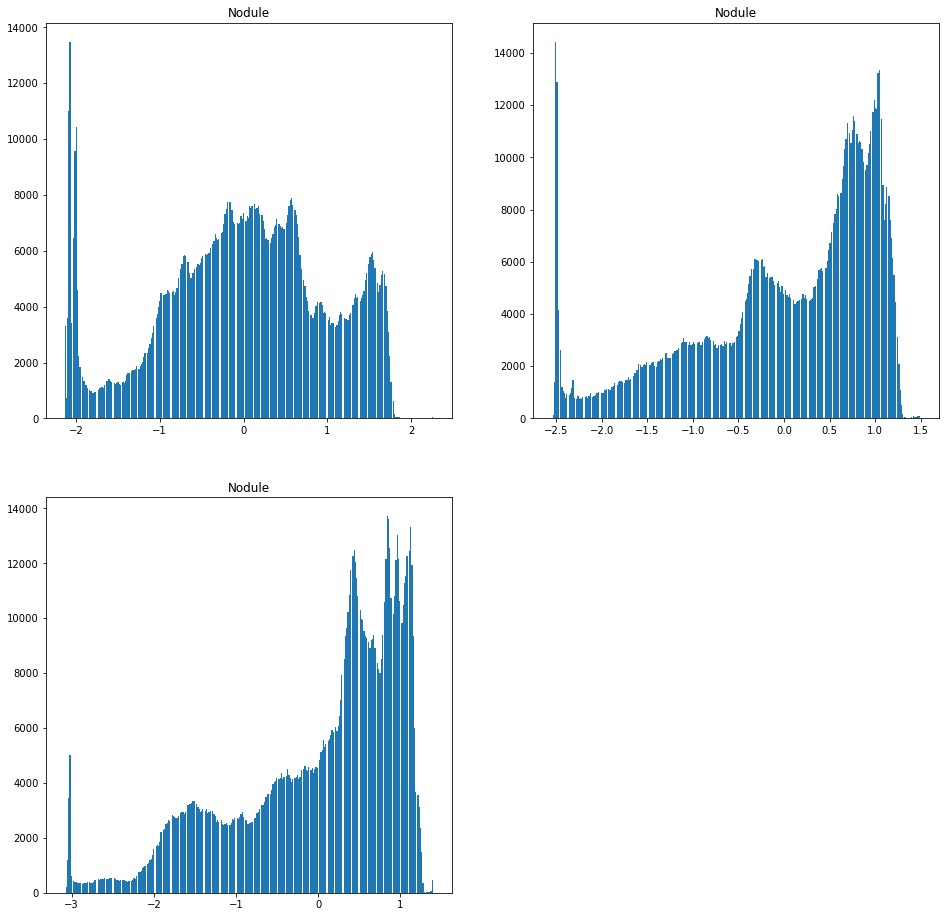

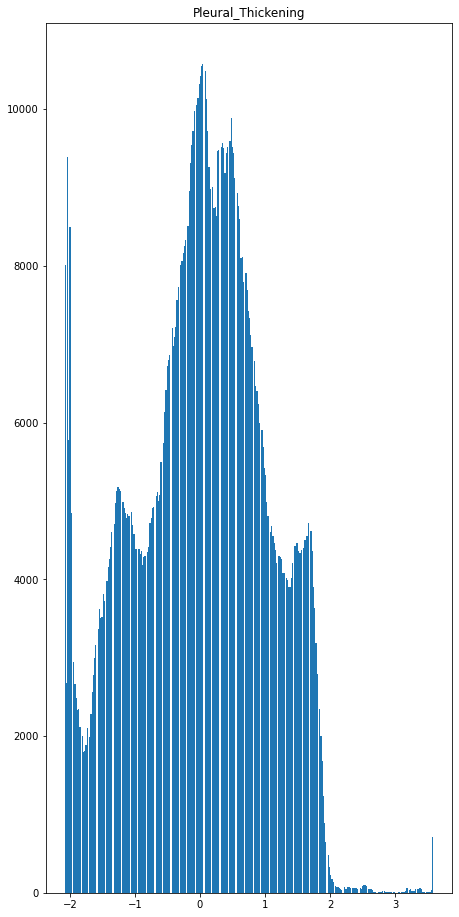

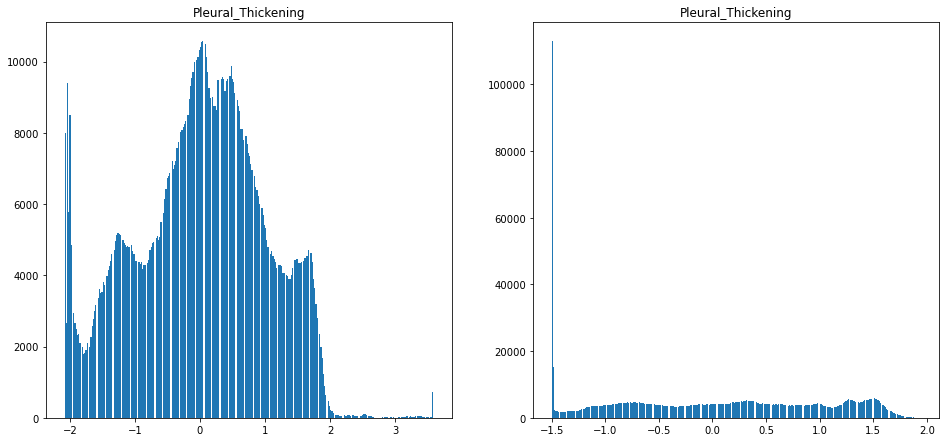

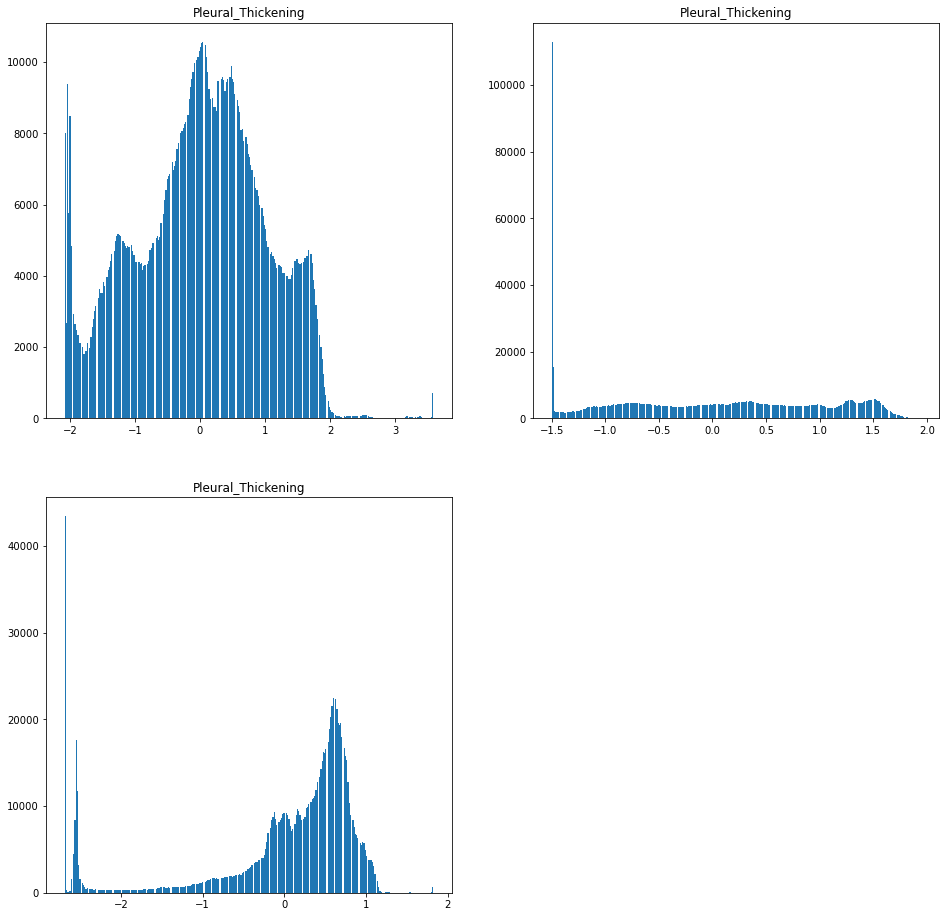

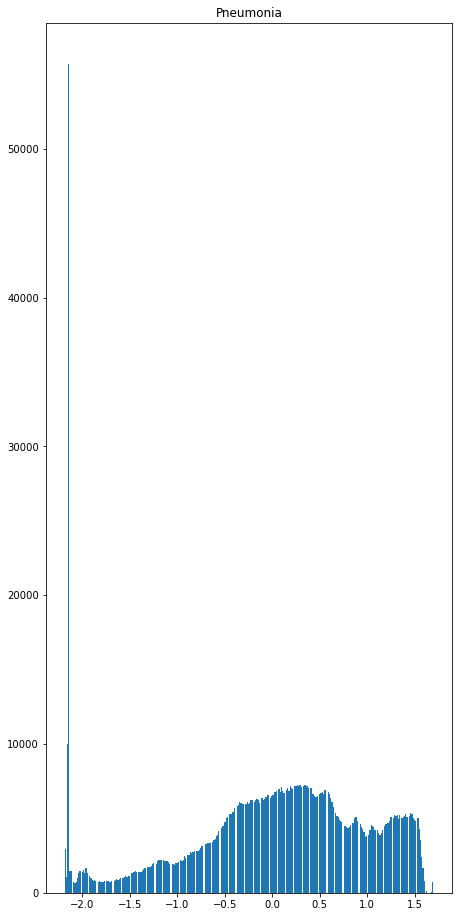

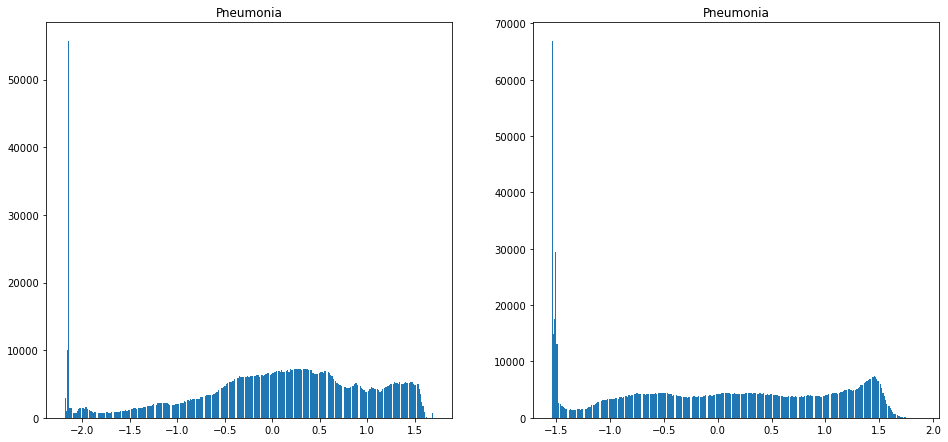

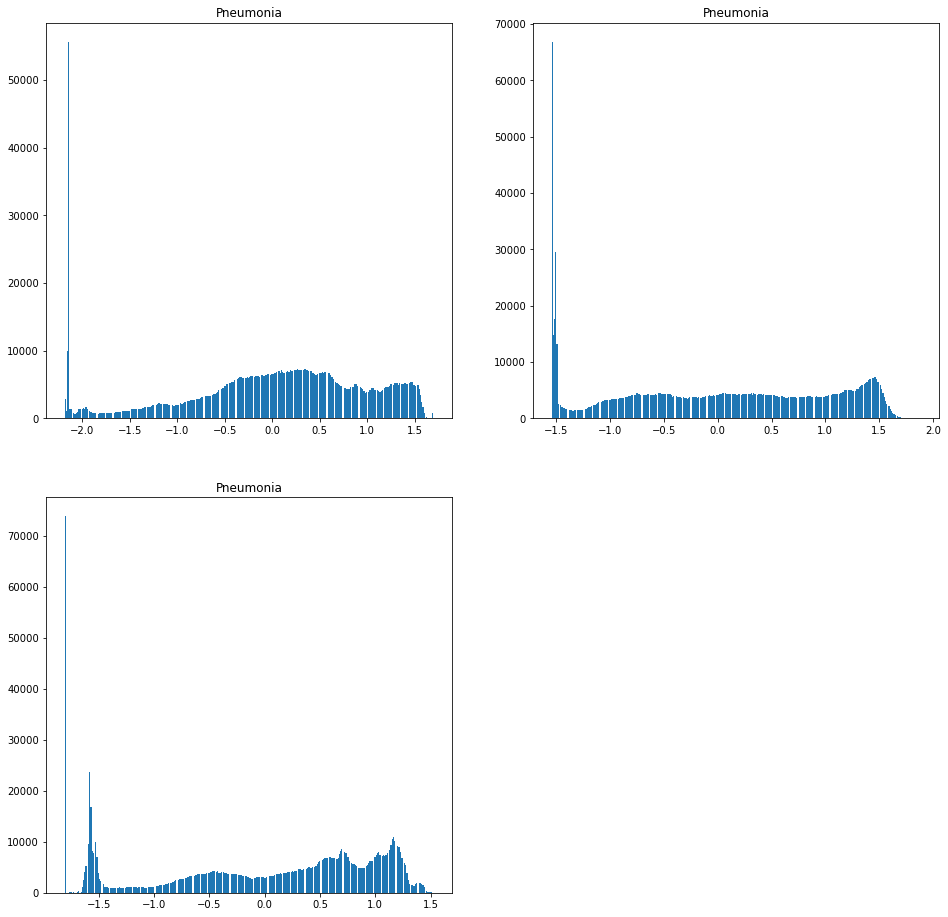

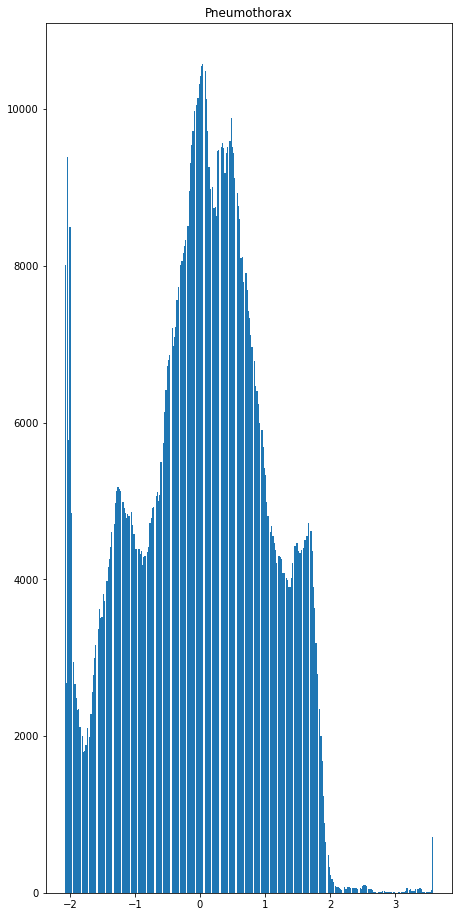

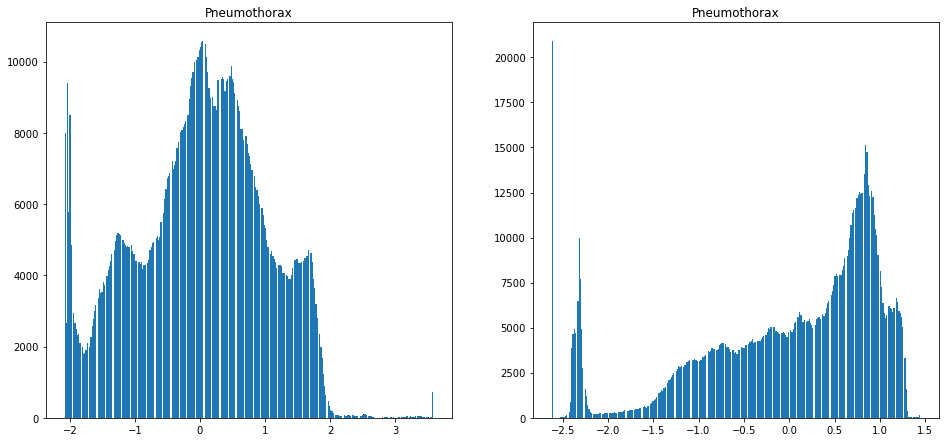

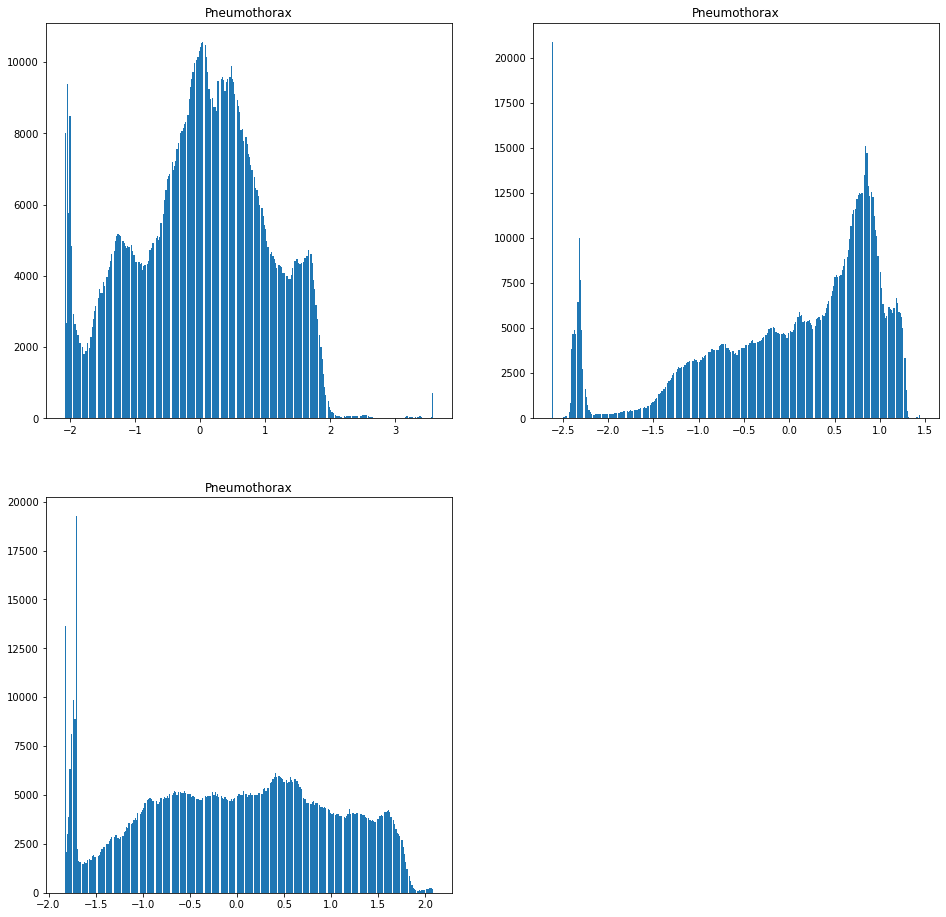

In [99]:
for l in labels:
    hist = sample_df[sample_df[l] == 1]
    data = []
    # For index of path in range 9
    for p in range(3):
        data.append((l, hist.iloc[p]["path"]))
        # Defined the variable fig
        fig =plt.figure(figsize=(16, 16))
        columns = 2

        for i in range(len(data) ):
            plt.subplot(len(data) / columns + 1, columns, i + 1).set_title(l)
            var = plt.imread(data[i][1])
            plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=300)
            # Show the image
            #img_path = data[i][1]
            #ax = fig.add-subplot(3, 2, i) # nrows, ncols, index
            #img = plt.imread(img_path)
            #plt.imshow(img, cmap='gray')



### Intensity values
To quickly visualize patterns

Infilteration stands out with a diffuse pattern of intensity, A similar pattern is observed in effusion. These patterns do not match the observed pattern in pneumonia which is less intense. 
For a mass, there appear to be not only a tiny focus of very high intensity in the middle, but the intensity has a uniform color, the kind not seen in any other disease